In [1]:
import numpy as np
import pandas as pd
import psutil
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.metrics import matthews_corrcoef, accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle

2025-04-23 19:32:50.758433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745425970.835212   22794 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745425970.860000   22794 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745425971.012490   22794 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745425971.012513   22794 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745425971.012514   22794 computation_placer.cc:177] computation placer alr

# Functions

In [2]:
data_5000 = {}

In [3]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def result_plot(_dict, name, folder, model_name):
    """
    Plot results for multiclass classification
    """
    with open('results_5000_mc.txt', 'a') as file:
        file.write(f"{name}: {_dict}")
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall", "MCC", "precision", "recall", "f1-score", "support", 'Benign', 'Bruteforce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing',
       'Web']
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]:.6f}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    if name in higher:
        name = name.capitalize()
        ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    else:
        ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Score')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    if (model_name == ""):
        plt.savefig(f"images/results/{folder}/5000/{name}.png")
    else:
        plt.savefig(f"images/results/{folder}/5000/{name}_{model_name}.png")

def plot_mc(y_pred, y_test, model_name, mc_results = {}):
    """
    Plots Precision, Recall and F1 scores for each class in multiclass classification
    """
    cr = classification_report(y_pred, y_test, output_dict=True)
    for key, name in cr.items():
        if key not in ['accuracy', 'macro avg', 'weighted avg'] and int(key) in attack_dict:
            mc_results[attack_dict[int(key)]] = cr[key]
    mc_results = pd.DataFrame(mc_results).drop(['support'], axis = 0)
    for key in mc_results.keys():
        data_5000[key] = mc_results[key].to_dict()
    x = pd.DataFrame(data_5000).transpose().to_dict()
    with open('results_5000_precision.txt', 'a') as f:
        f.write(f"{model_name}: {x['precision']}")
    with open('results_5000_recall.txt', 'a') as f:
        f.write(f"{model_name}: {x['recall']}")
    with open('results_5000_f1.txt', 'a') as f:
        f.write(f"{model_name}: {x['f1-score']}")
    for key in mc_results.keys():
        result_plot(mc_results[key], key, "multiclass_by_class", model_name)

# Load data

In [4]:
data = pd.read_csv('data/CIC_IoT2023/custom/multiclass_classification_data_5000.csv')

In [5]:
data = data.drop(['Unnamed: 0', 'label', 'Class'], axis=1)

In [6]:
data.head()

flow_duration  Header_Length  Protocol Type  Duration       Rate  \
0            0.0            0.0           0.99     65.27   1.232415   
1            0.0           54.0           6.00     64.00  31.840037   
2            0.0            0.0           0.99     63.36   2.481472   
3            0.0           54.0           6.00     64.00   4.499163   
4            0.0           54.0           6.00     64.00  15.849033   

       Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  ...  \
0   1.232415    0.0              0.0              0.0              0.0  ...   
1  31.840037    0.0              0.0              1.0              0.0  ...   
2   2.481472    0.0              0.0              0.0              0.0  ...   
3   4.499163    0.0              0.0              0.0              0.0  ...   
4  15.849033    0.0              0.0              0.0              0.0  ...   

        Std  Tot size           IAT  Number   Magnitue    Radius  Covariance  \
0  0.617394     42.18  8.312856e+07     9.5   9.184764  0.874489    2.990124   
1  0.000000     54.00  8.309343e+07     9.5  10.392305  0.000000    0.000000   
2  0.617394     42.18  8.314964e+07     9.5   9.184764  0.874489    2.990124   
3  0.000000     54.00  8.333215e+07     9.5  10.392305  0.000000    0.000000   
4  0.000000     54.00  8.307156e+07     9.5  10.392305  0.000000    0.000000   

   Variance  Weight  Attack Type  
0      0.13  141.55         DDoS  
1      0.00  141.55         DDoS  
2      0.13  141.55         DDoS  
3      0.00  141.55         DDoS  
4      0.00  141.55         DDoS  

[5 rows x 47 columns]

In [7]:
data.tail()

flow_duration  Header_Length  Protocol Type  Duration       Rate  \
39995      36.155368        28633.7            7.1     116.9  10.558204   
39996     436.989332         2014.3            5.5      62.9  16.392893   
39997       0.218856         3889.2            5.4     106.5  27.824803   
39998      63.663335         1715.2           11.5      96.8   4.135345   
39999      28.865871        48128.0            8.2     105.4  30.624000   

           Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  \
39995  10.558204    0.0              0.0              0.0              0.0   
39996  16.392893    0.0              0.0              0.0              0.0   
39997  27.824803    0.0              0.0              0.0              0.0   
39998   4.135345    0.0              0.0              0.0              0.0   
39999  30.624000    0.0              0.0              0.0              0.0   

       ...          Std  Tot size           IAT  Number   Magnitue  \
39995  ...   356.197567     140.6  1.666013e+08    13.5  22.344181   
39996  ...     3.023964      69.2  2.420115e-03     5.5  11.581493   
39997  ...   778.624312     686.5  1.712120e-02     5.5  29.905248   
39998  ...   108.960070     109.9  1.666013e+08    13.5  19.310294   
39999  ...  1407.994664     831.1  1.666013e+08    13.5  35.234034   

            Radius    Covariance  Variance  Weight  Attack Type  
39995   504.642883  1.280880e+05       1.0   244.6   Bruteforce  
39996     4.276530  3.052958e+01       0.3    38.5   Bruteforce  
39997  1101.141062  9.659848e+05       0.9    38.5   Bruteforce  
39998   153.970479  1.187418e+04       1.0   244.6   Bruteforce  
39999  1996.814533  2.011423e+06       1.0   244.6   Bruteforce  

[5 rows x 47 columns]

In [8]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

In [9]:
X.head()

flow_duration  Header_Length  Protocol Type  Duration       Rate  \
0            0.0            0.0           0.99     65.27   1.232415   
1            0.0           54.0           6.00     64.00  31.840037   
2            0.0            0.0           0.99     63.36   2.481472   
3            0.0           54.0           6.00     64.00   4.499163   
4            0.0           54.0           6.00     64.00  15.849033   

       Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  ...  \
0   1.232415    0.0              0.0              0.0              0.0  ...   
1  31.840037    0.0              0.0              1.0              0.0  ...   
2   2.481472    0.0              0.0              0.0              0.0  ...   
3   4.499163    0.0              0.0              0.0              0.0  ...   
4  15.849033    0.0              0.0              0.0              0.0  ...   

         AVG       Std  Tot size           IAT  Number   Magnitue    Radius  \
0  42.180879  0.617394     42.18  8.312856e+07     9.5   9.184764  0.874489   
1  54.000000  0.000000     54.00  8.309343e+07     9.5  10.392305  0.000000   
2  42.180879  0.617394     42.18  8.314964e+07     9.5   9.184764  0.874489   
3  54.000000  0.000000     54.00  8.333215e+07     9.5  10.392305  0.000000   
4  54.000000  0.000000     54.00  8.307156e+07     9.5  10.392305  0.000000   

   Covariance  Variance  Weight  
0    2.990124      0.13  141.55  
1    0.000000      0.00  141.55  
2    2.990124      0.13  141.55  
3    0.000000      0.00  141.55  
4    0.000000      0.00  141.55  

[5 rows x 46 columns]

In [10]:
y

0              DDoS
1              DDoS
2              DDoS
3              DDoS
4              DDoS
            ...    
39995    Bruteforce
39996    Bruteforce
39997    Bruteforce
39998    Bruteforce
39999    Bruteforce
Name: Attack Type, Length: 40000, dtype: object

In [11]:
le = LabelEncoder()

data['Attack Number'] = le.fit_transform(y)
y = data['Attack Number']

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
attack_dict = {}
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    attack_dict[val] = le.inverse_transform([val])[0]
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: Benign
1: Bruteforce
2: DDoS
3: DoS
4: Mirai
5: Recon
6: Spoofing
7: Web


# Multiclass Classification

In [14]:
results_dict = {}

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((34000, 46), (34000,), (6000, 46), (6000,))

In [16]:
# Unique train values
unique, counts = np.unique(y_train, return_counts=True)
for x, y in zip(unique, counts):
    print(f"{x}: {y}")

0: 4229
1: 4242
2: 4212
3: 4292
4: 4243
5: 4262
6: 4264
7: 4256


In [17]:
# Unique train values
unique, counts = np.unique(y_test, return_counts=True)
for x, y in zip(unique, counts):
    print(f"{x}: {y}")

0: 771
1: 758
2: 788
3: 708
4: 757
5: 738
6: 736
7: 744


# K Nearest Neighbour

In [18]:
%%time

start = time.time()

process = psutil.Process()
cpu_before = process.cpu_percent(interval=None)
mem_before = process.memory_info().rss

knn_clf = KNeighborsClassifier(n_jobs=8)
knn_clf.fit(X_train, y_train)

y_pred = knn_clf.predict(X_test)

cpu_after = process.cpu_percent(interval=None)
mem_after = process.memory_info().rss

end = time.time()

KNN_time = end - start

CPU times: user 1.71 s, sys: 12.9 ms, total: 1.72 s
Wall time: 529 ms


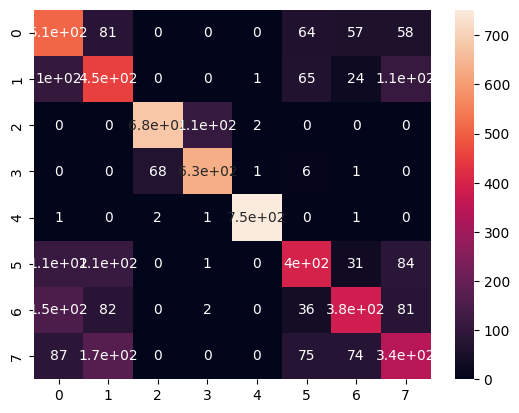

In [19]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [20]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [21]:
latencies = []
for sample in X_test:
    start_time = time.perf_counter()  # Higher precision than time.time()
    _ = knn_clf.predict(sample.reshape(1, -1))  # Reshape for single sample
    latencies.append(time.perf_counter() - start_time)
mean_latency = np.mean(latencies) * 1000
std_latency = np.std(latencies) * 1000

print(f"CPU usage: {cpu_after - cpu_before}%")
memory = (mem_after - mem_before) / (1024 * 1024)
print(f"Memory usage: {(mem_after - mem_before) / (1024 * 1024)} MB")
print(f"Memory usage: {(mem_after - mem_before) / (1024)} KB")
print(f"Memory usage: {(mem_after - mem_before)} B")
print(f"Prediction time: {end - start} seconds")

CPU usage: 323.8%
Memory usage: 12.328125 MB
Memory usage: 12624.0 KB
Memory usage: 12926976 B
Prediction time: 0.5288612842559814 seconds


In [22]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, mean_latency, std_latency, memory, KNN_time]
results_dict["kNN"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Mean Latency (ms)", "Standard Latency (ms)", "Memory Usage (MB)", "Time"])

In [23]:
results_df

Accuracy  Precision        F1    Recall       MCC       MAE       MSE  \
kNN  0.691167   0.697398  0.691055  0.691167  0.647975  1.167833  5.981833   

         RMSE  Mean Latency (ms)  Standard Latency (ms)  Memory Usage (MB)  \
kNN  2.445779           2.226666               0.586299          12.328125   

         Time  
kNN  0.528861

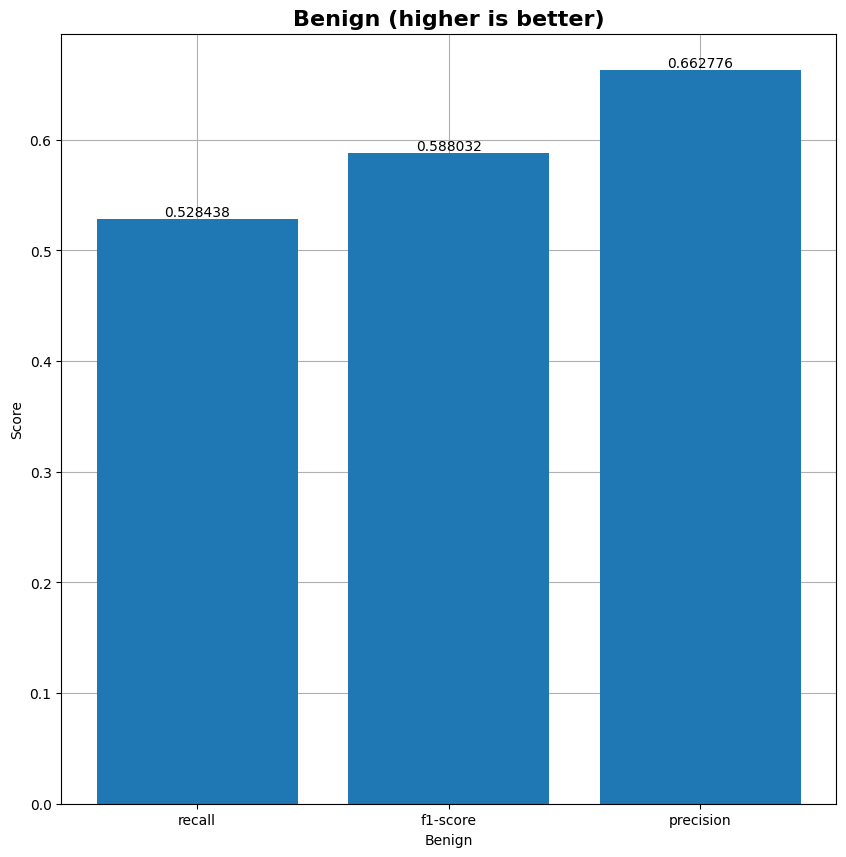

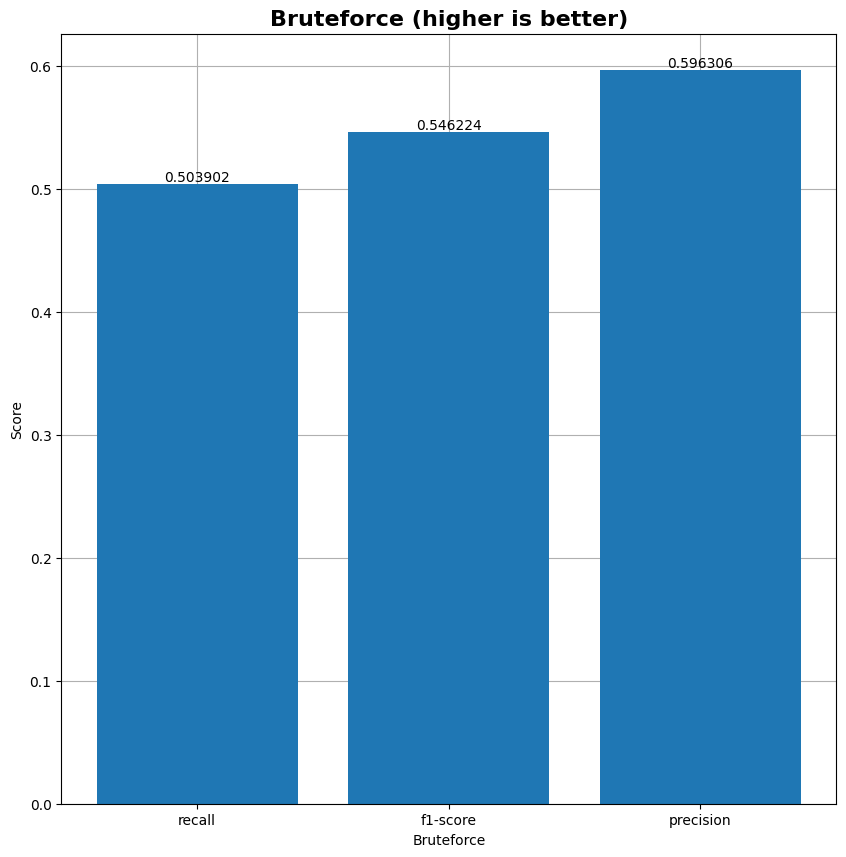

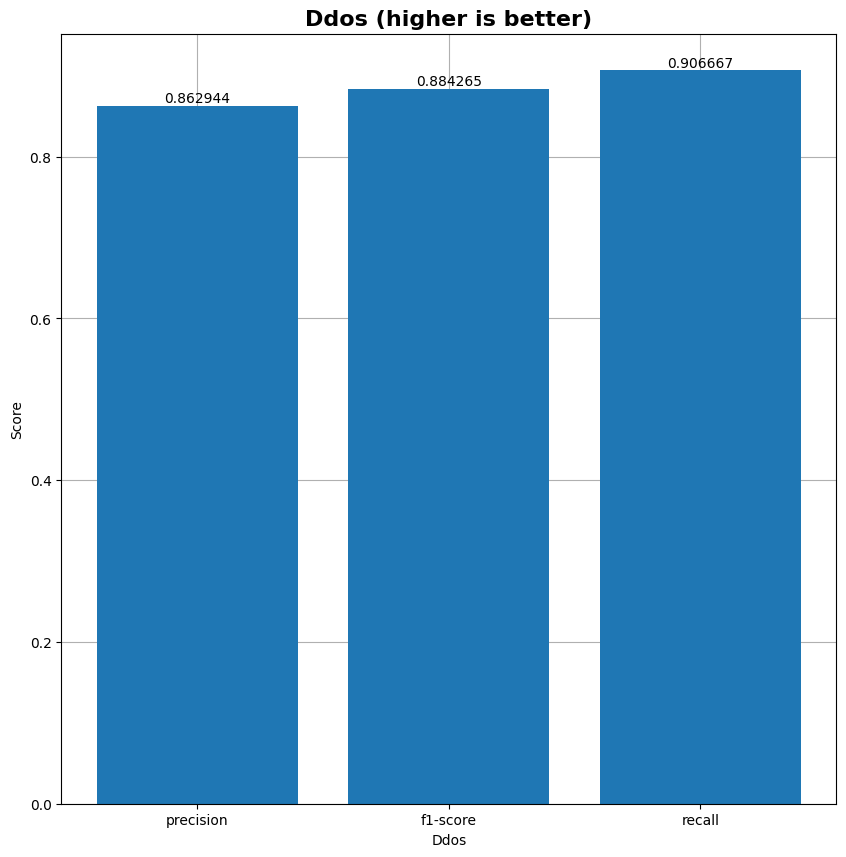

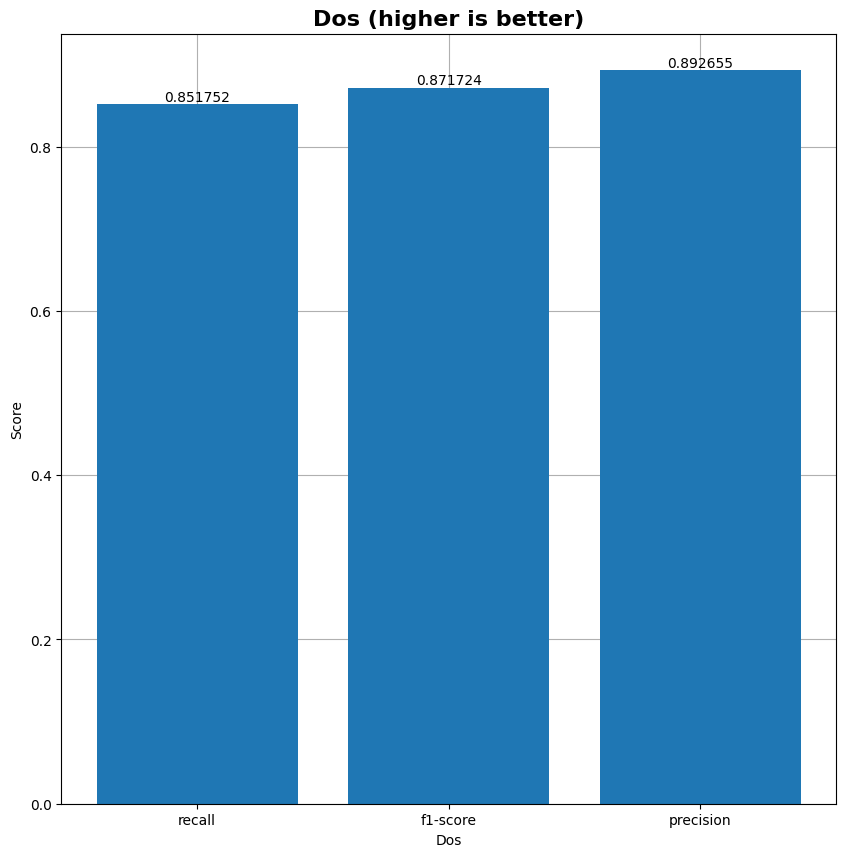

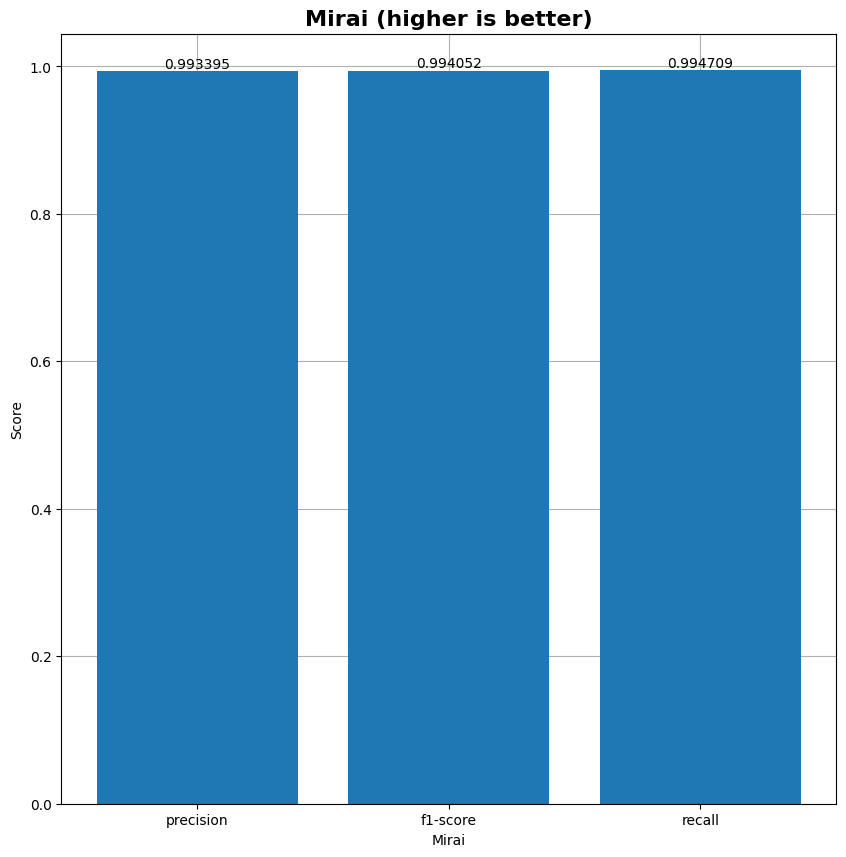

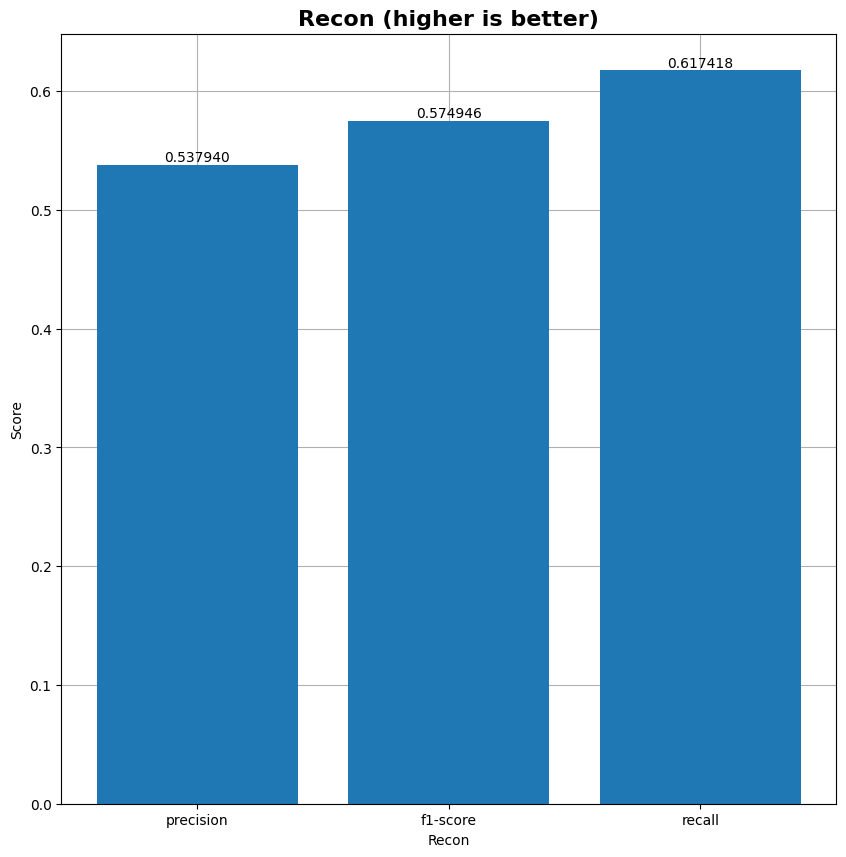

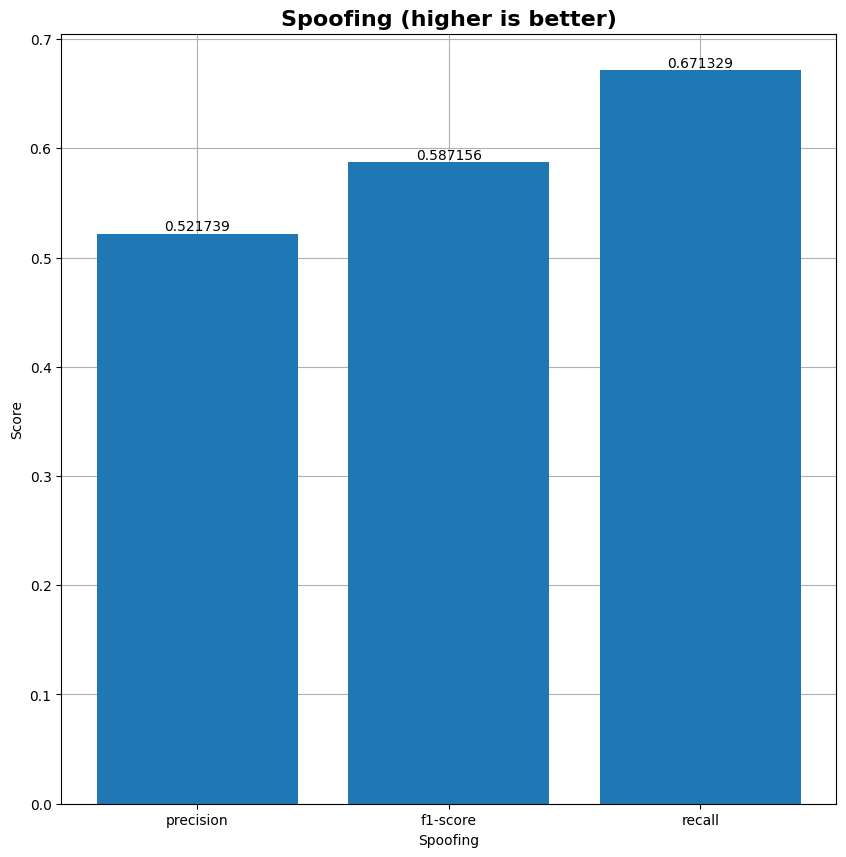

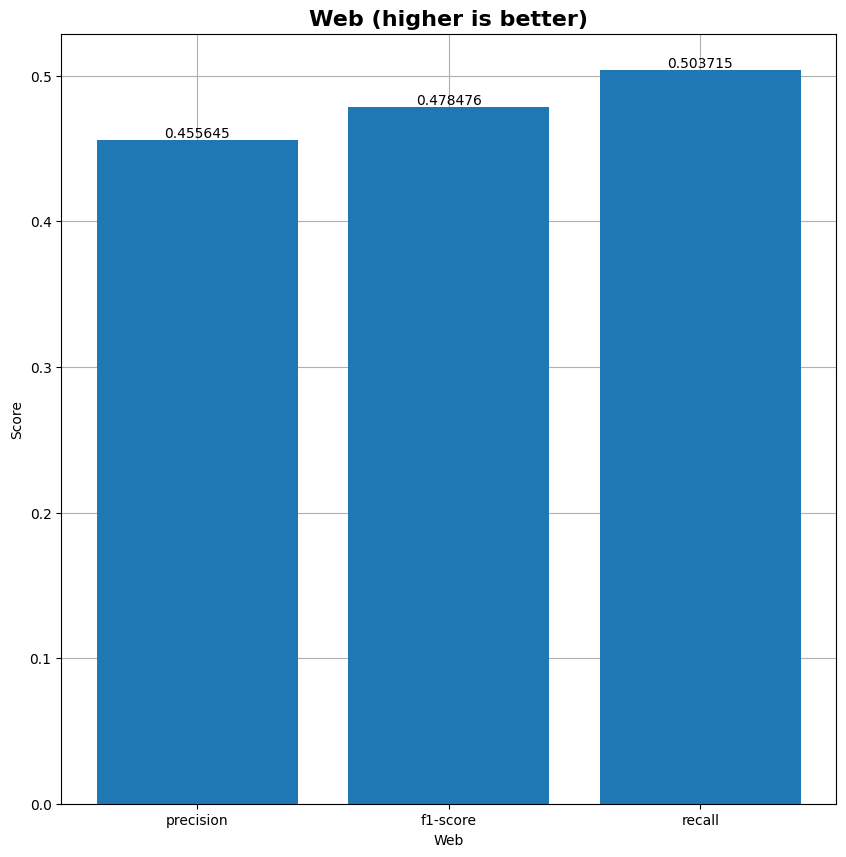

In [24]:
plot_mc(y_pred, y_test, "kNN")

In [25]:
model_name = "kNN_5000.sav"
pickle.dump(knn_clf, open(model_name, 'wb'))

# Logistic Regression

In [26]:
%%time

start = time.time()

process = psutil.Process()
cpu_before = process.cpu_percent(interval=None)
mem_before = process.memory_info().rss

lr_clf = LogisticRegression(max_iter = 10000, C = 0.1, random_state = 0, solver = 'saga', n_jobs=8)
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_test)

cpu_after = process.cpu_percent(interval=None)
mem_after = process.memory_info().rss

end = time.time()

LR_time = end - start

CPU times: user 2min 19s, sys: 160 ms, total: 2min 19s
Wall time: 2min 19s


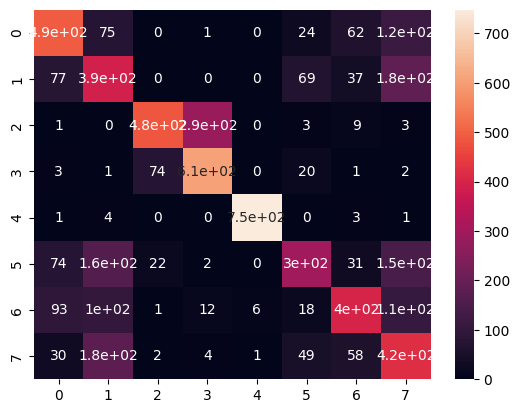

In [27]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [28]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [29]:
latencies = []
for sample in X_test:
    start_time = time.perf_counter()  # Higher precision than time.time()
    _ = lr_clf.predict(sample.reshape(1, -1))  # Reshape for single sample
    latencies.append(time.perf_counter() - start_time)
mean_latency = np.mean(latencies) * 1000
std_latency = np.std(latencies) * 1000

print(f"CPU usage: {cpu_after - cpu_before}%")
memory = (mem_after - mem_before) / (1024 * 1024)
print(f"Memory usage: {(mem_after - mem_before) / (1024 * 1024)} MB")
print(f"Memory usage: {(mem_after - mem_before) / (1024)} KB")
print(f"Memory usage: {(mem_after - mem_before)} B")
print(f"Prediction time: {end - start} seconds")

CPU usage: 99.8%
Memory usage: 18.03125 MB
Memory usage: 18464.0 KB
Memory usage: 18907136 B
Prediction time: 139.98025250434875 seconds


In [30]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, mean_latency, std_latency, memory, LR_time]
results_dict["LR"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Mean Latency (ms)", "Standard Latency (ms)", "Memory Usage (MB)", "Time"])

In [31]:
results_df

Accuracy  Precision        F1    Recall       MCC       MAE       MSE  \
kNN  0.691167   0.697398  0.691055  0.691167  0.647975  1.167833  5.981833   
LR   0.640000   0.659405  0.640927  0.640000  0.591002  1.278500  6.325833   

         RMSE  Mean Latency (ms)  Standard Latency (ms)  Memory Usage (MB)  \
kNN  2.445779           2.226666               0.586299          12.328125   
LR   2.515121           0.123944               0.040489          18.031250   

           Time  
kNN    0.528861  
LR   139.980253

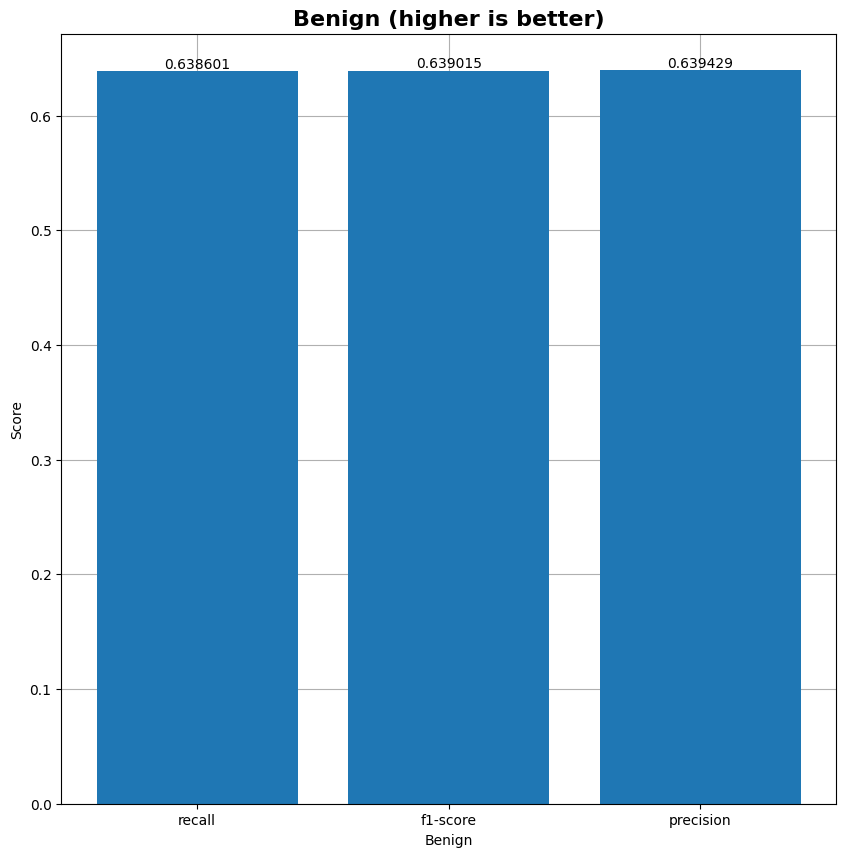

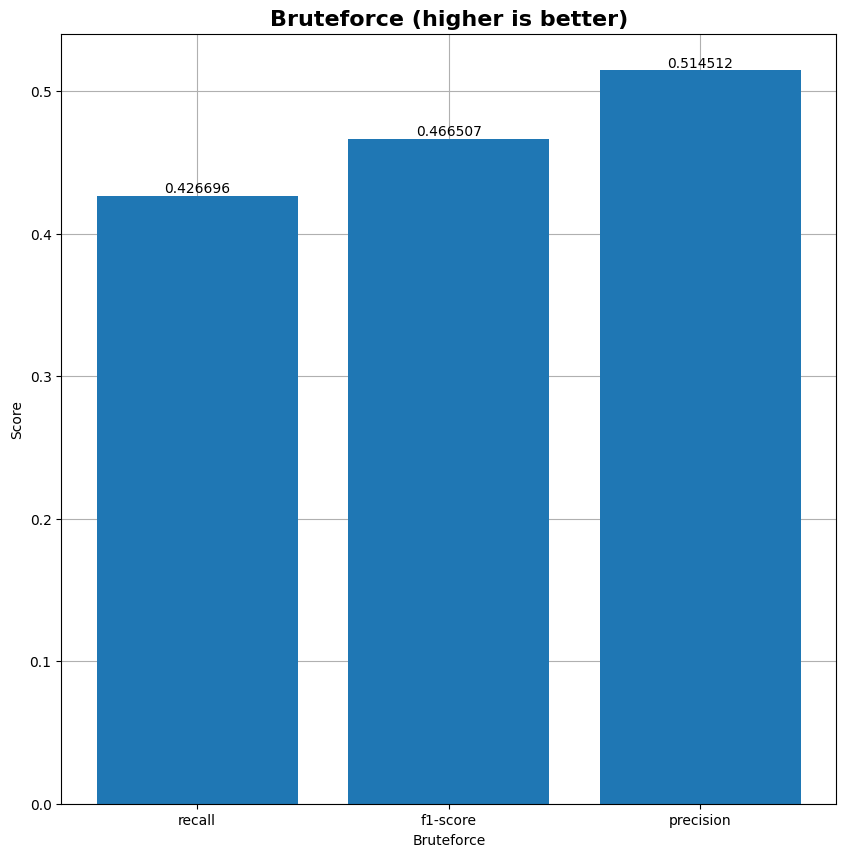

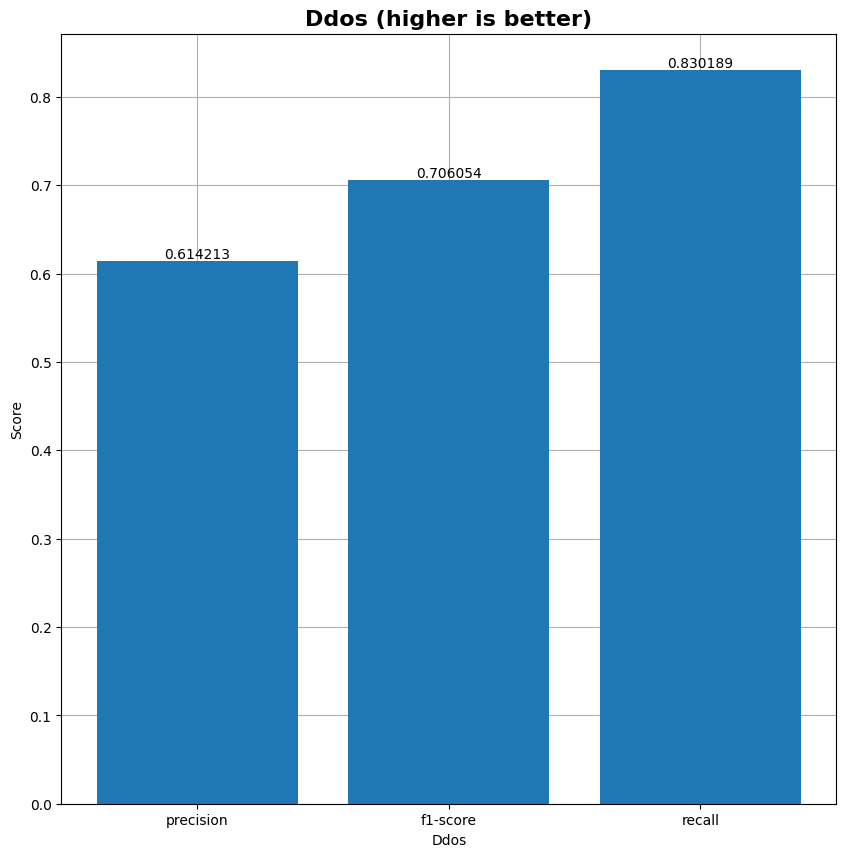

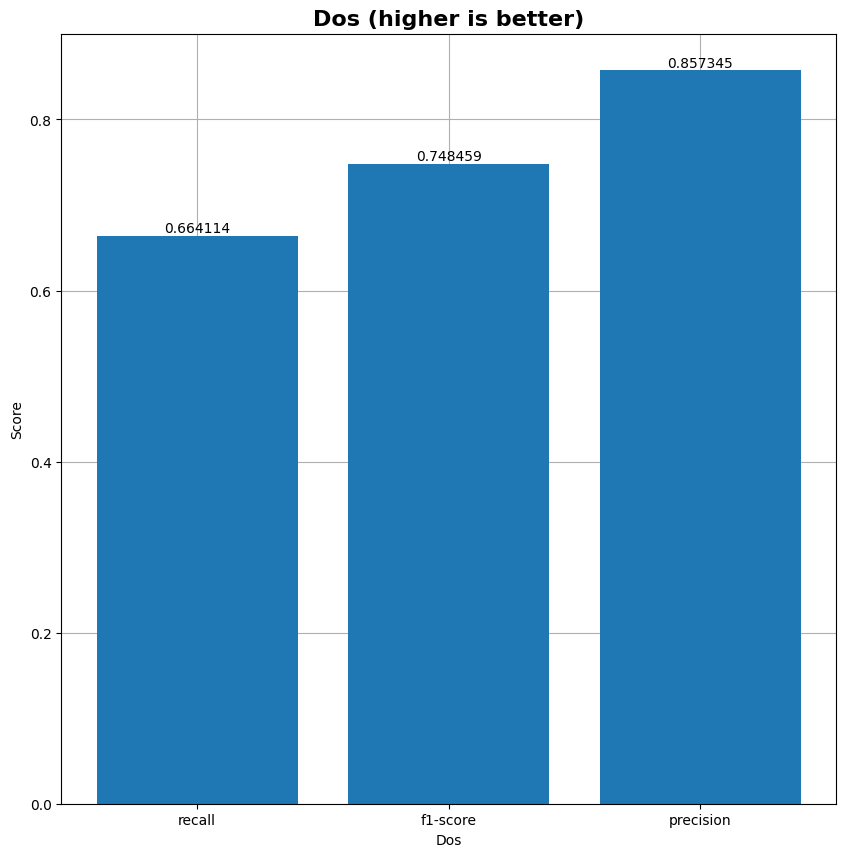

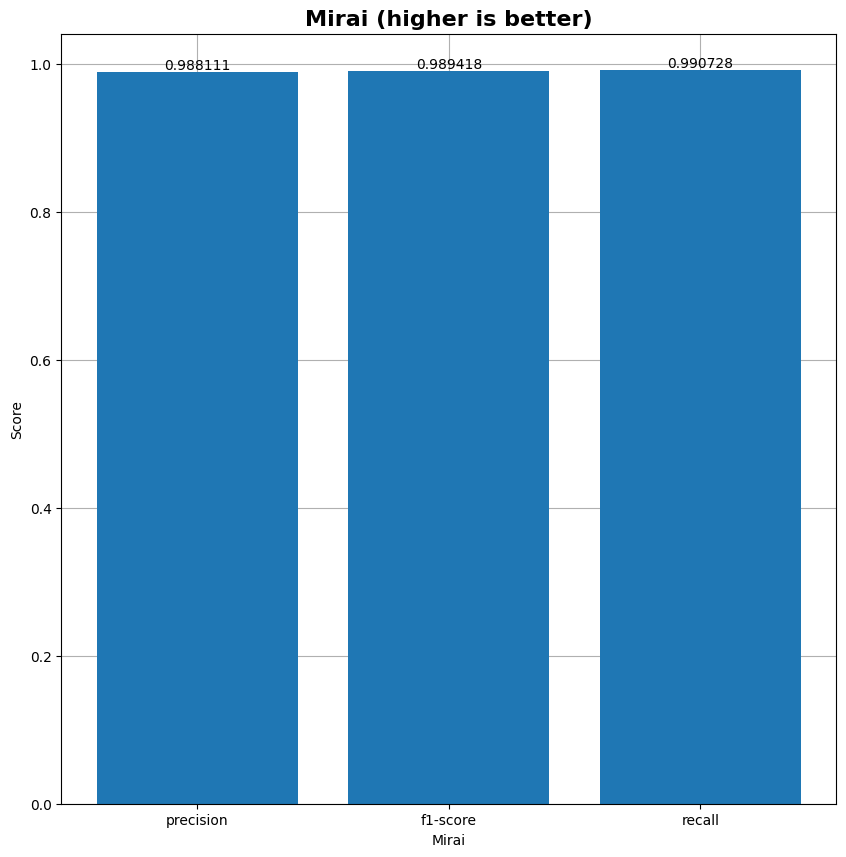

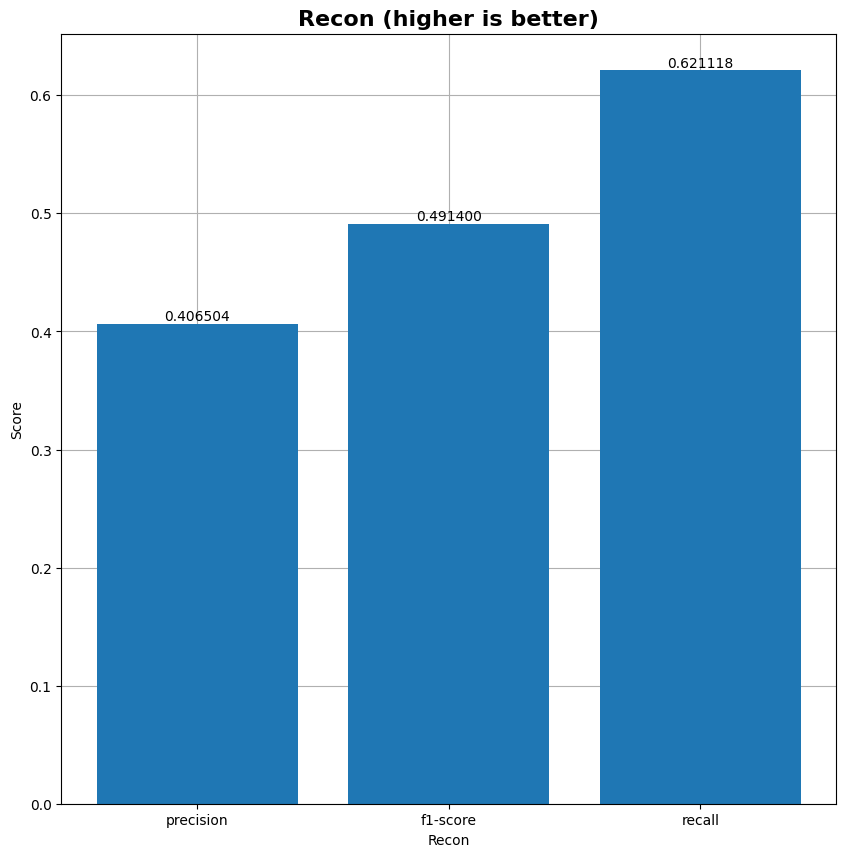

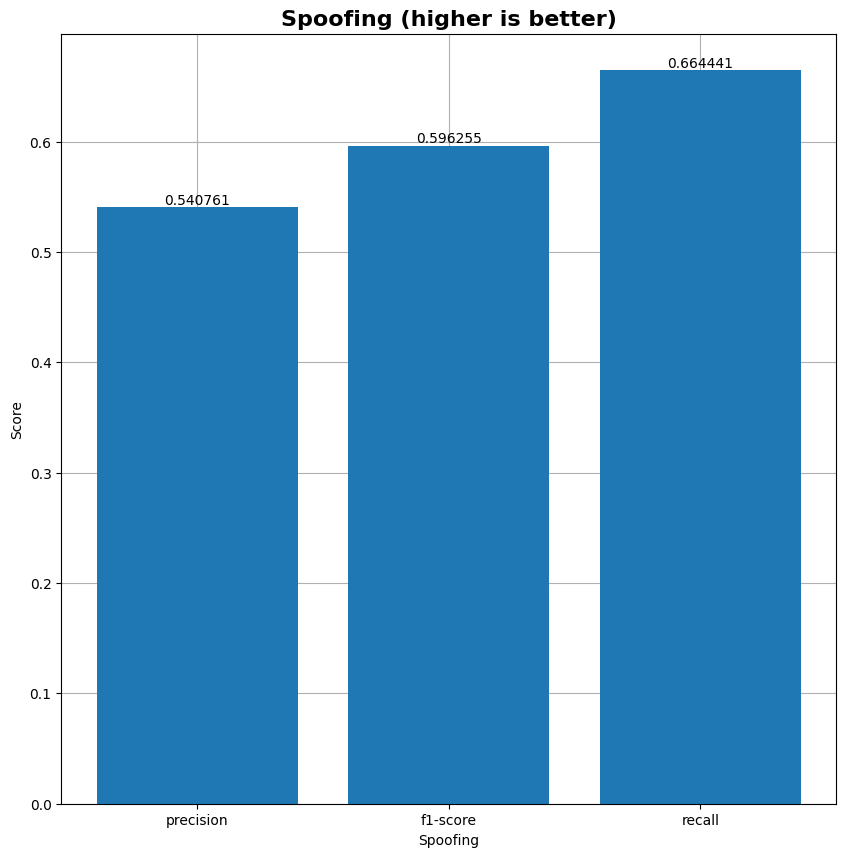

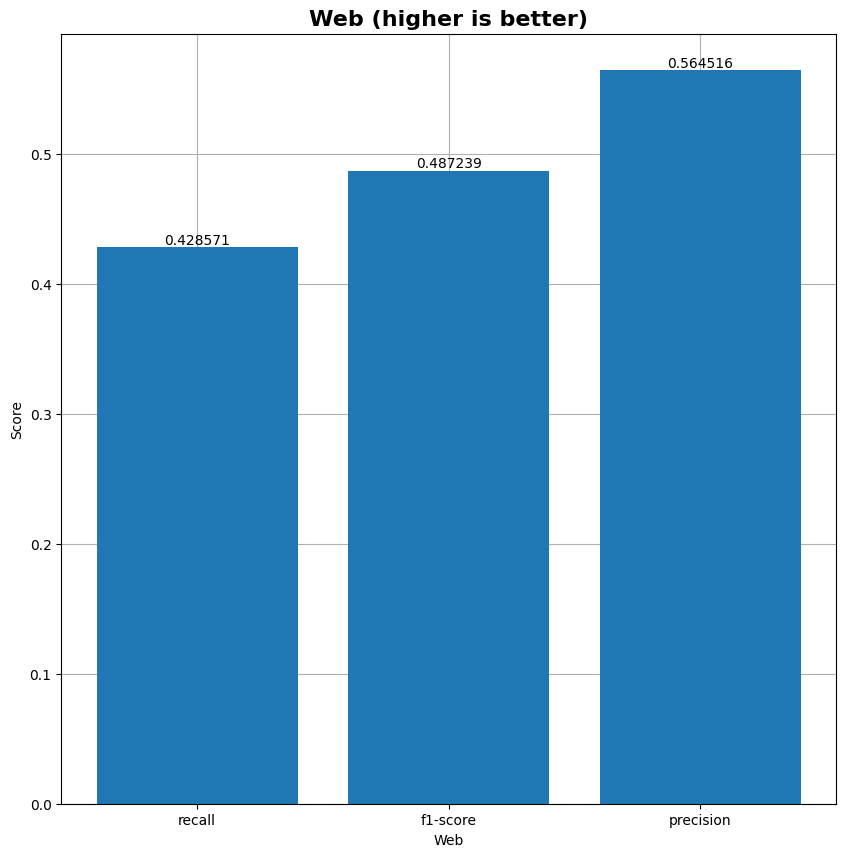

In [32]:
plot_mc(y_pred, y_test, "LR")

In [33]:
model_name = "LR_5000.sav"
pickle.dump(lr_clf, open(model_name, 'wb'))

# Random Forest

In [34]:
%%time

start = time.time()

process = psutil.Process()
cpu_before = process.cpu_percent(interval=None)
mem_before = process.memory_info().rss

rf_clf = RandomForestClassifier(n_jobs=8)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

cpu_after = process.cpu_percent(interval=None)
mem_after = process.memory_info().rss

end = time.time()

RF_time = end - start

CPU times: user 11.8 s, sys: 118 ms, total: 11.9 s
Wall time: 1.79 s


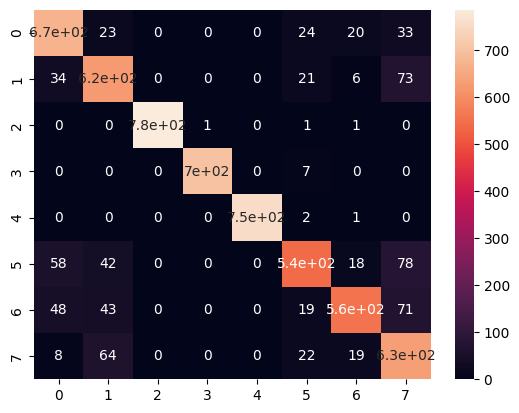

In [35]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [36]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [37]:
latencies = []
for sample in X_test:
    start_time = time.perf_counter()  # Higher precision than time.time()
    _ = rf_clf.predict(sample.reshape(1, -1))  # Reshape for single sample
    latencies.append(time.perf_counter() - start_time)
mean_latency = np.mean(latencies) * 1000
std_latency = np.std(latencies) * 1000

print(f"CPU usage: {cpu_after - cpu_before}%")
memory = (mem_after - mem_before) / (1024 * 1024)
print(f"Memory usage: {(mem_after - mem_before) / (1024 * 1024)} MB")
print(f"Memory usage: {(mem_after - mem_before) / (1024)} KB")
print(f"Memory usage: {(mem_after - mem_before)} B")
print(f"Prediction time: {end - start} seconds")

CPU usage: 667.4%
Memory usage: 136.3515625 MB
Memory usage: 139624.0 KB
Memory usage: 142974976 B
Prediction time: 1.7878637313842773 seconds


In [38]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, mean_latency, std_latency, memory, RF_time]
results_dict["RF"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Mean Latency (ms)", "Standard Latency (ms)", "Memory Usage (MB)", "Time"])

In [39]:
results_df

Accuracy  Precision        F1    Recall       MCC       MAE       MSE  \
kNN  0.691167   0.697398  0.691055  0.691167  0.647975  1.167833  5.981833   
LR   0.640000   0.659405  0.640927  0.640000  0.591002  1.278500  6.325833   
RF   0.877167   0.882256  0.877560  0.877167  0.860233  0.472333  2.386000   

         RMSE  Mean Latency (ms)  Standard Latency (ms)  Memory Usage (MB)  \
kNN  2.445779           2.226666               0.586299          12.328125   
LR   2.515121           0.123944               0.040489          18.031250   
RF   1.544668          26.711837               7.628707         136.351562   

           Time  
kNN    0.528861  
LR   139.980253  
RF     1.787864

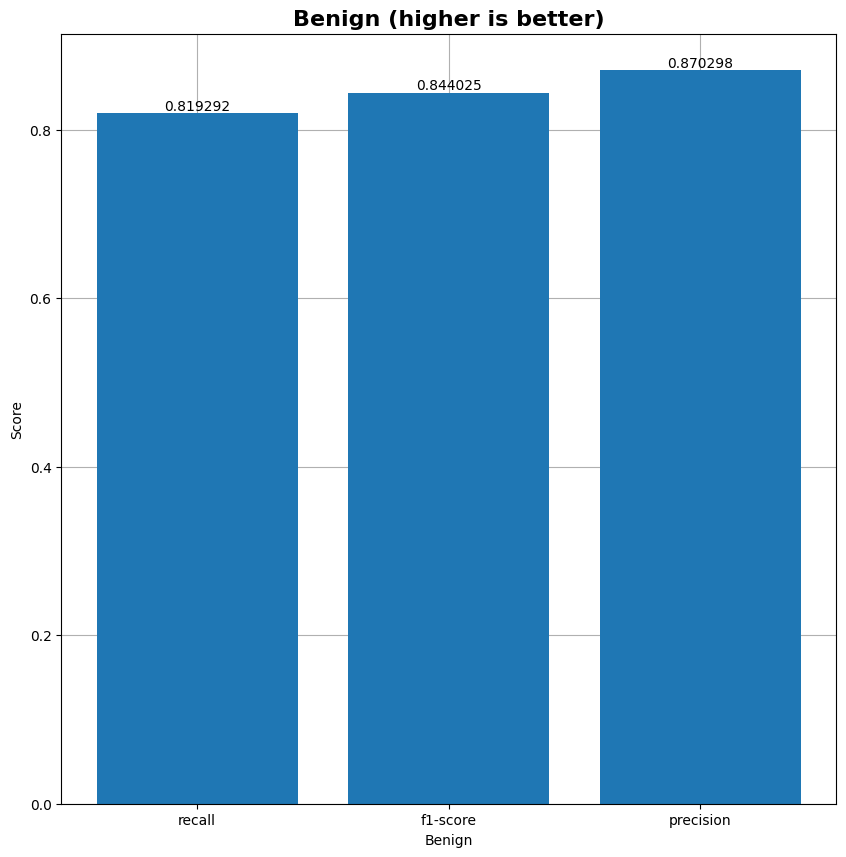

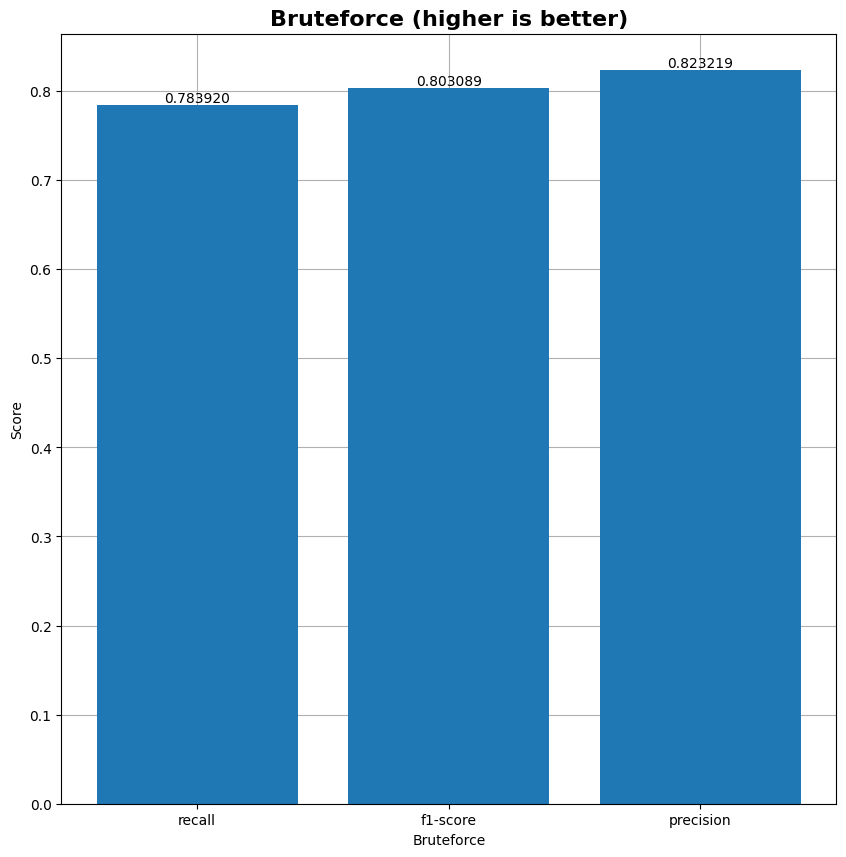

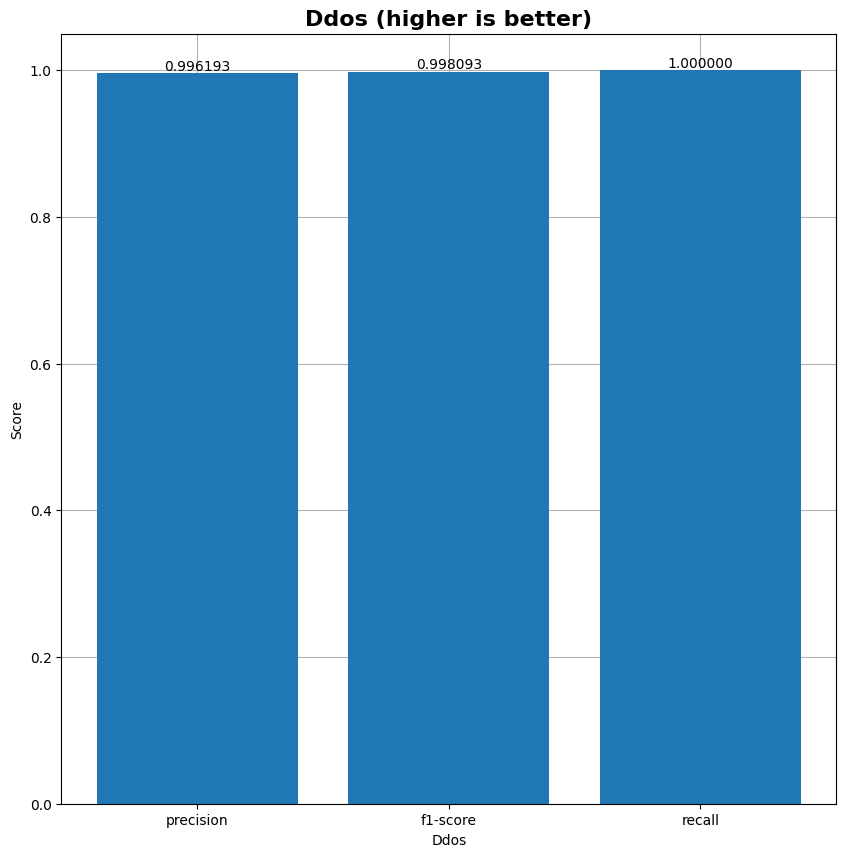

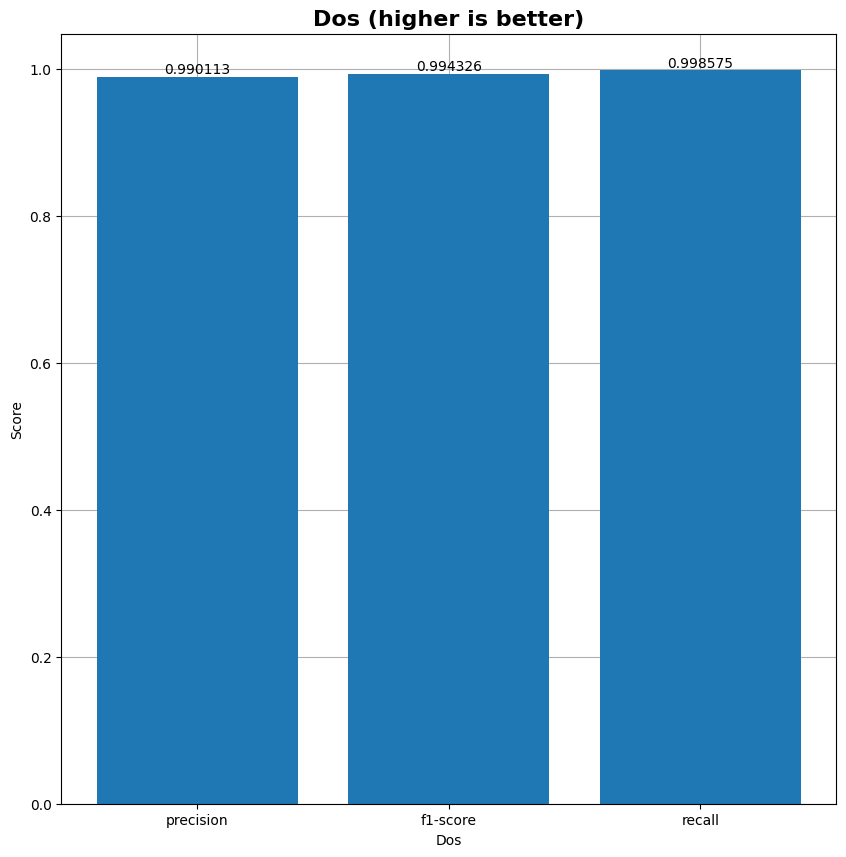

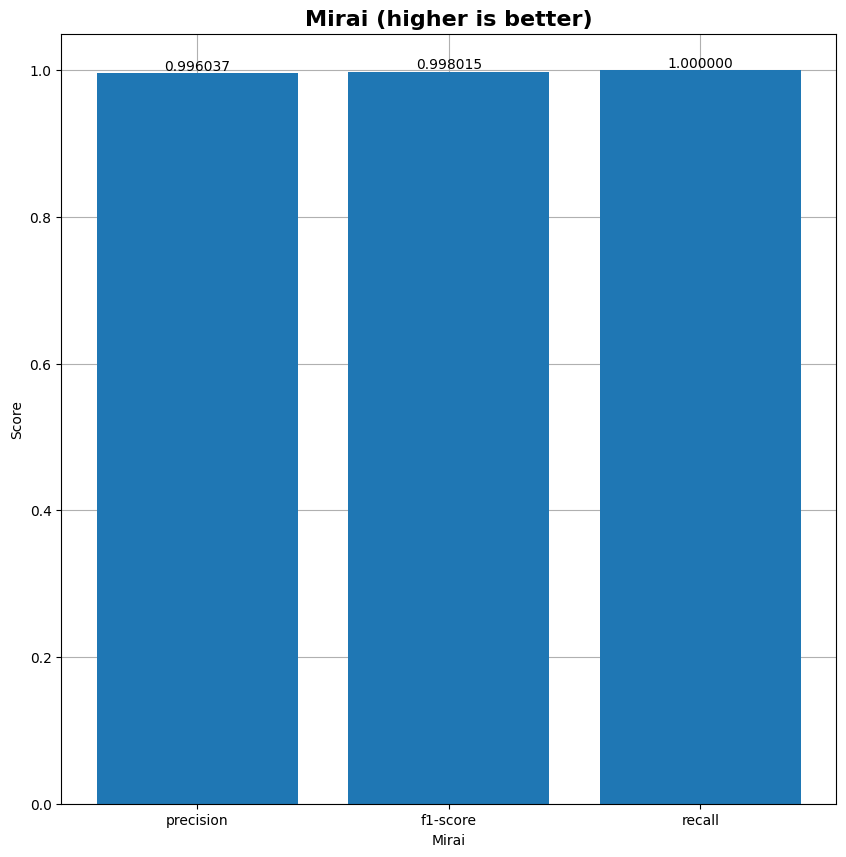

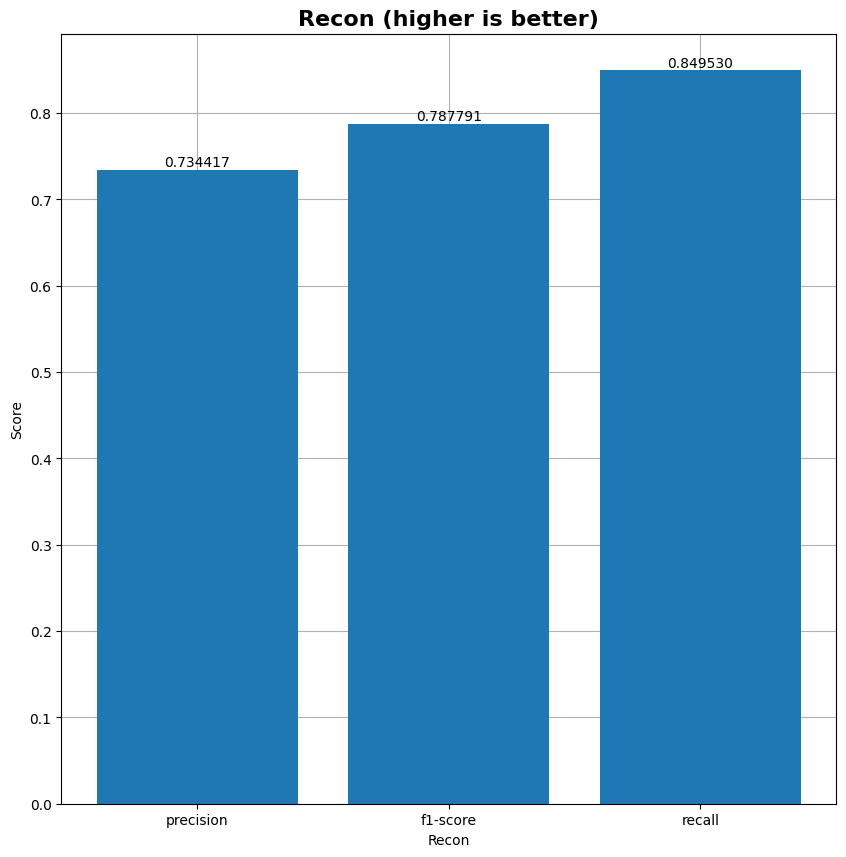

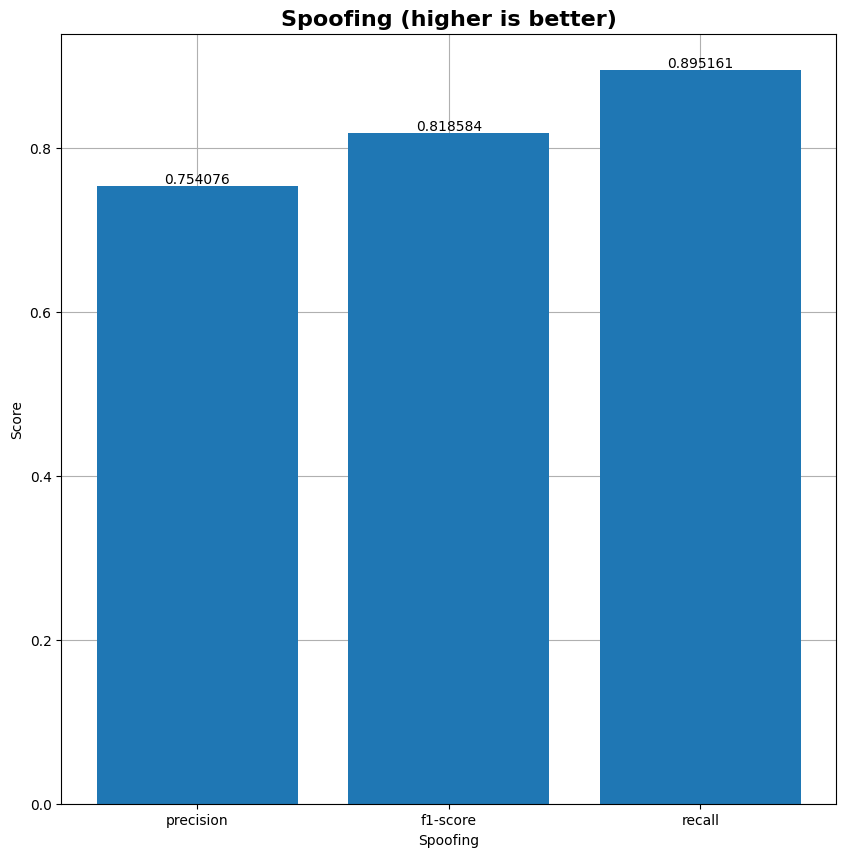

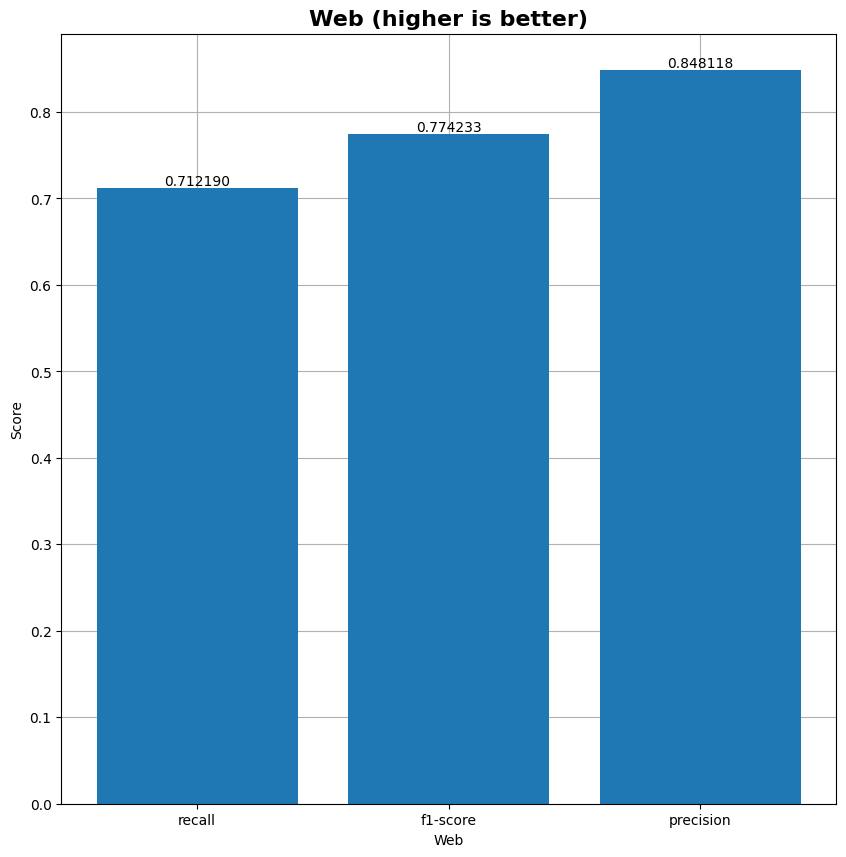

In [40]:
plot_mc(y_pred, y_test, "RF")

In [41]:
model_name = "RF_5000.sav"
pickle.dump(rf_clf, open(model_name, 'wb'))

# XGBoost

In [42]:
%%time

start = time.time()

process = psutil.Process()
cpu_before = process.cpu_percent(interval=None)
mem_before = process.memory_info().rss

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

cpu_after = process.cpu_percent(interval=None)
mem_after = process.memory_info().rss

end = time.time()

XGB_time = end - start

CPU times: user 1min 10s, sys: 161 ms, total: 1min 10s
Wall time: 10.9 s


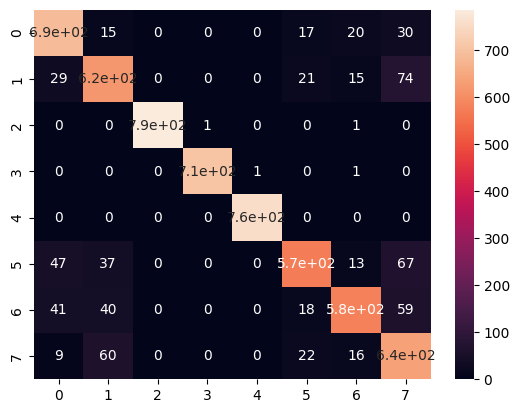

In [43]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [44]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [45]:
latencies = []
for sample in X_test:
    start_time = time.perf_counter()  # Higher precision than time.time()
    _ = xgb_clf.predict(sample.reshape(1, -1))  # Reshape for single sample
    latencies.append(time.perf_counter() - start_time)
mean_latency = np.mean(latencies) * 1000
std_latency = np.std(latencies) * 1000

print(f"CPU usage: {cpu_after - cpu_before}%")
memory = (mem_after - mem_before) / (1024 * 1024)
print(f"Memory usage: {(mem_after - mem_before) / (1024 * 1024)} MB")
print(f"Memory usage: {(mem_after - mem_before) / (1024)} KB")
print(f"Memory usage: {(mem_after - mem_before)} B")
print(f"Prediction time: {end - start} seconds")

CPU usage: 649.2%
Memory usage: 137.5859375 MB
Memory usage: 140888.0 KB
Memory usage: 144269312 B
Prediction time: 10.85221815109253 seconds


In [46]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, mean_latency, std_latency, memory, XGB_time]
results_dict["XGBoost"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Mean Latency (ms)", "Standard Latency (ms)", "Memory Usage (MB)", "Time"])

In [47]:
results_df

Accuracy  Precision        F1    Recall       MCC       MAE  \
kNN      0.691167   0.697398  0.691055  0.691167  0.647975  1.167833   
LR       0.640000   0.659405  0.640927  0.640000  0.591002  1.278500   
RF       0.877167   0.882256  0.877560  0.877167  0.860233  0.472333   
XGBoost  0.891000   0.894713  0.891339  0.891000  0.875862  0.434500   

              MSE      RMSE  Mean Latency (ms)  Standard Latency (ms)  \
kNN      5.981833  2.445779           2.226666               0.586299   
LR       6.325833  2.515121           0.123944               0.040489   
RF       2.386000  1.544668          26.711837               7.628707   
XGBoost  2.227833  1.492593           2.583272               4.464663   

         Memory Usage (MB)        Time  
kNN              12.328125    0.528861  
LR               18.031250  139.980253  
RF              136.351562    1.787864  
XGBoost         137.585938   10.852218

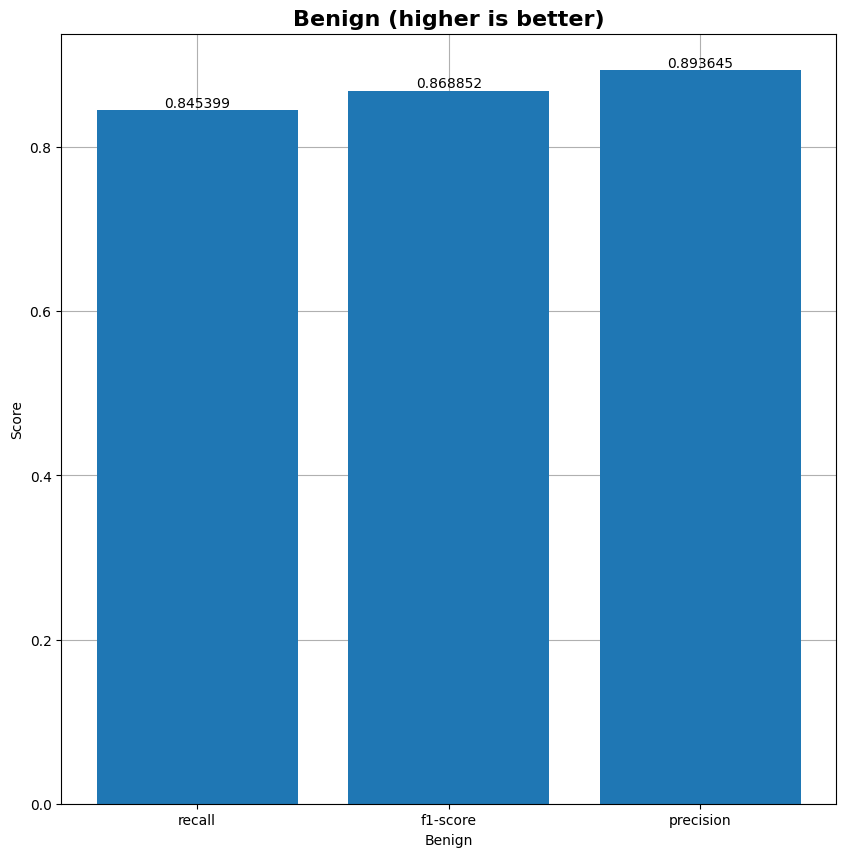

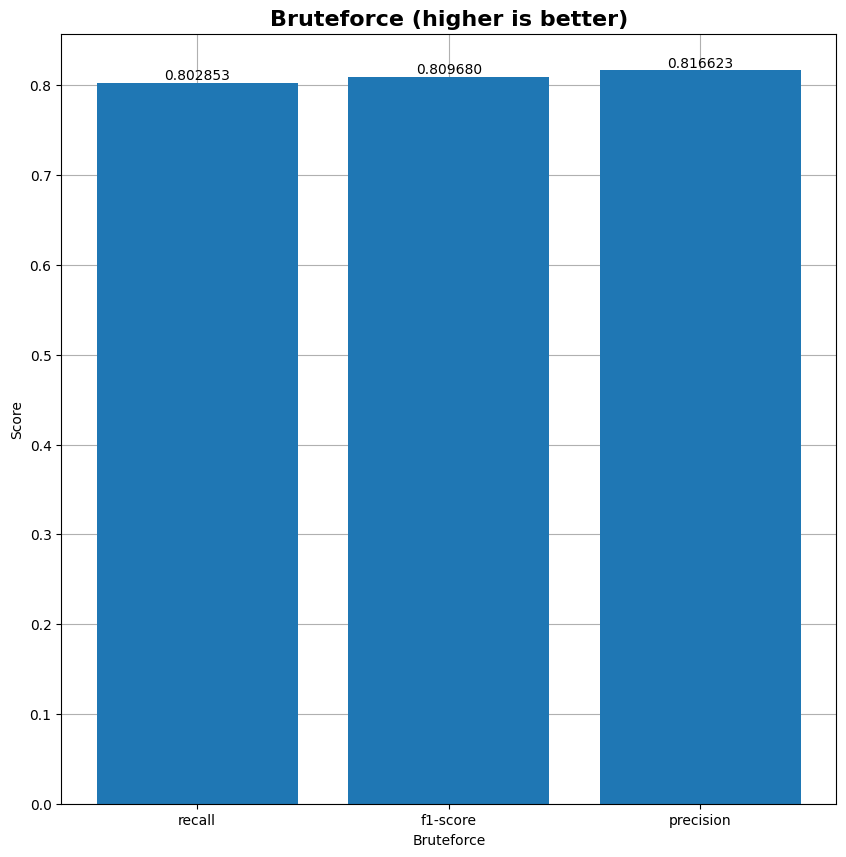

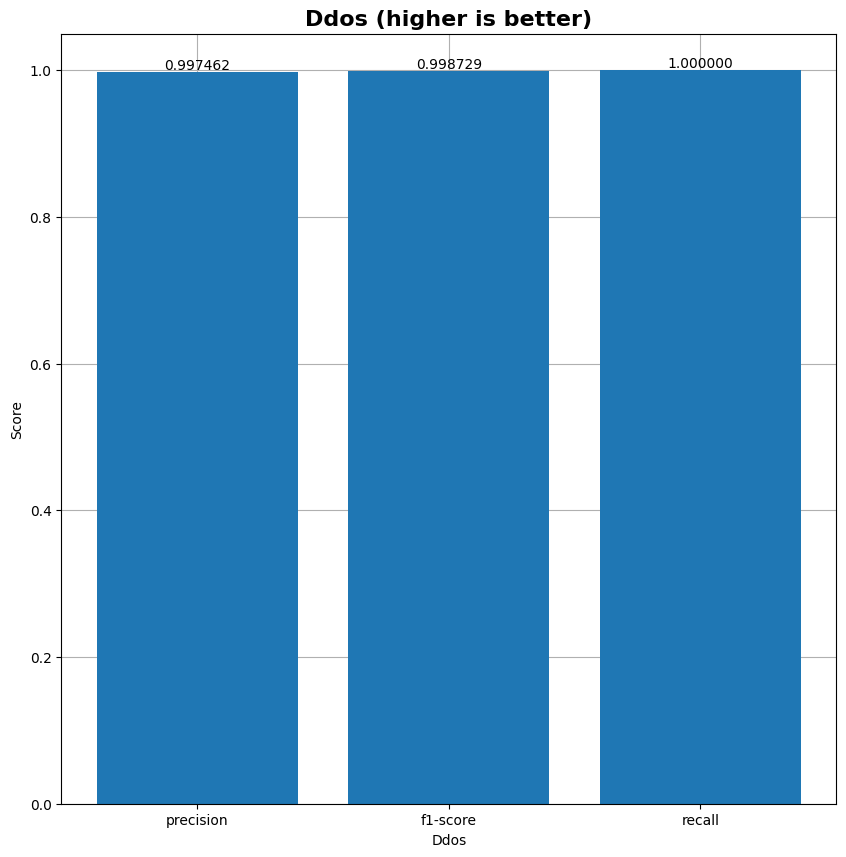

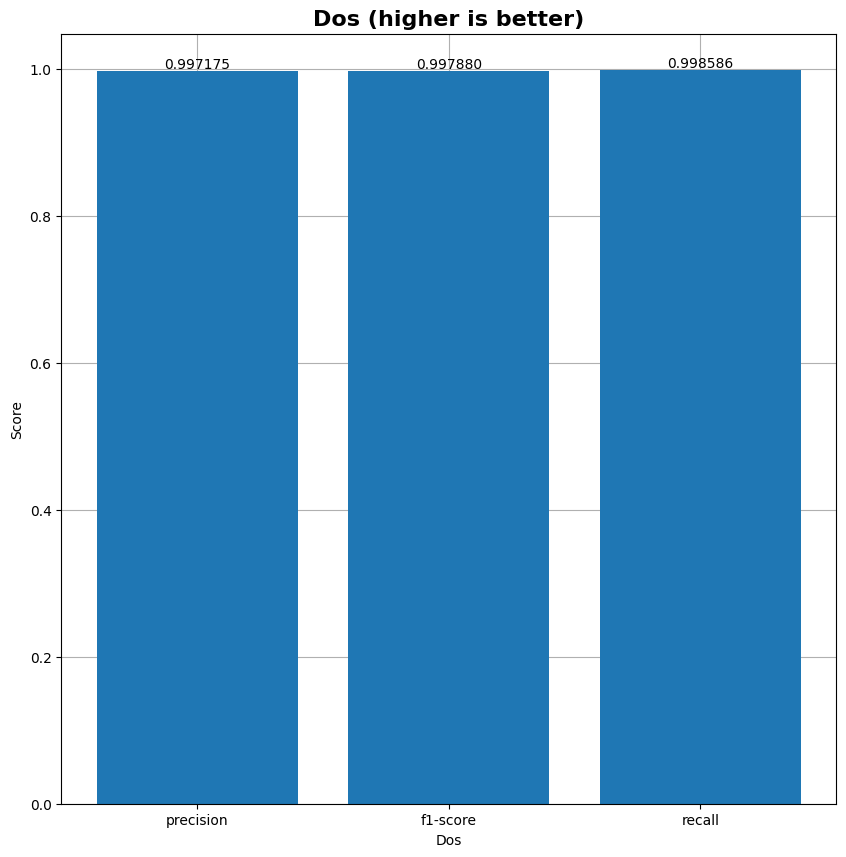

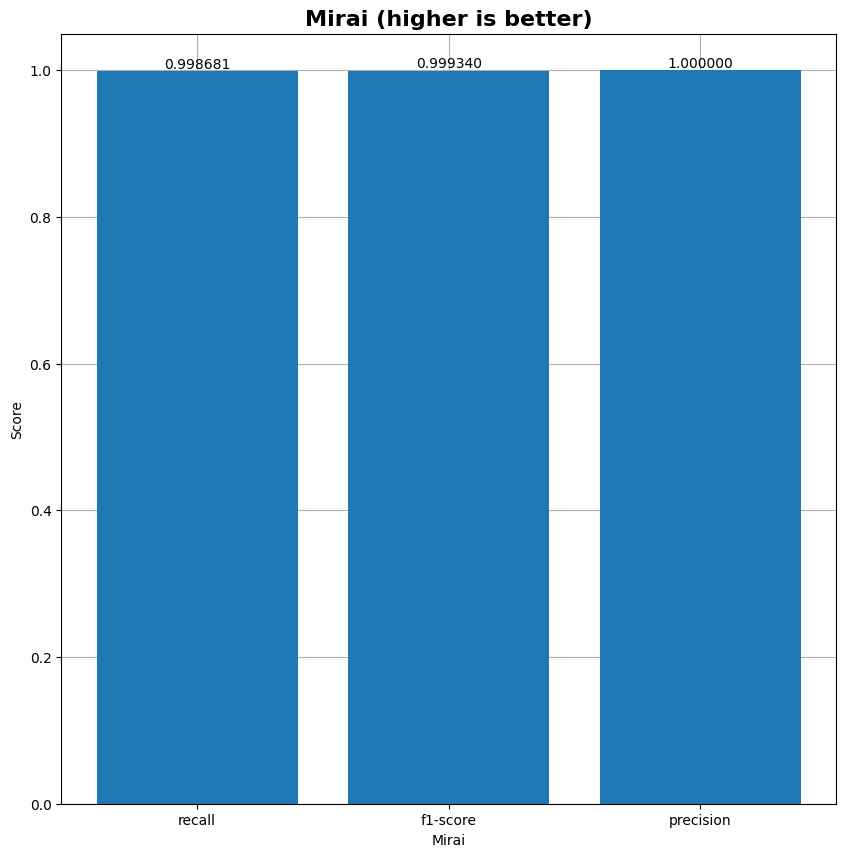

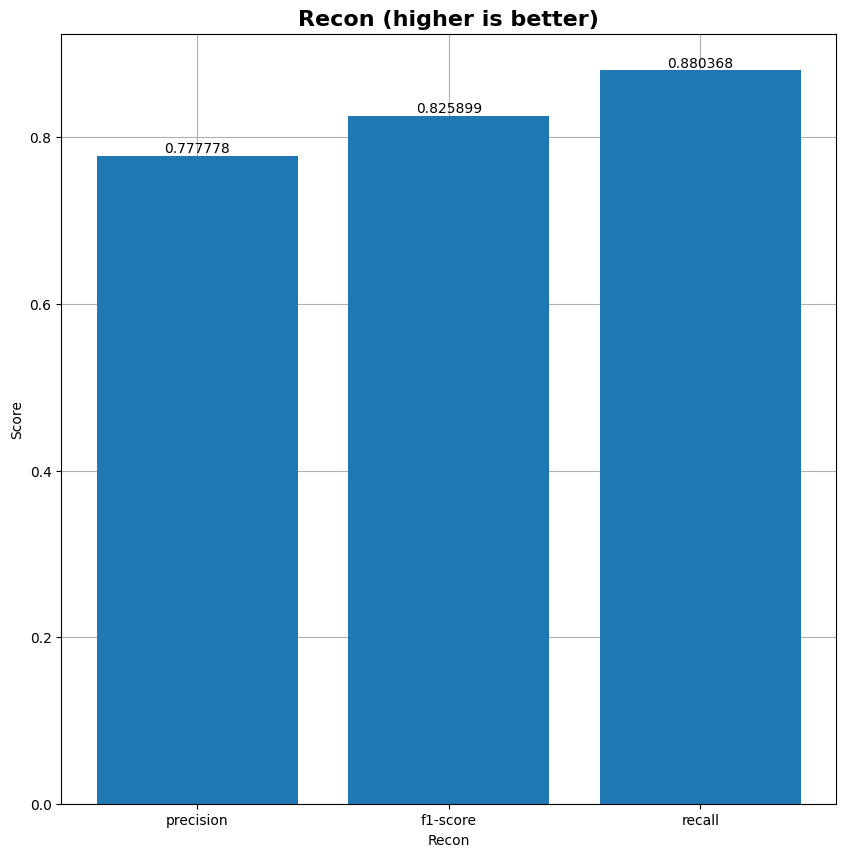

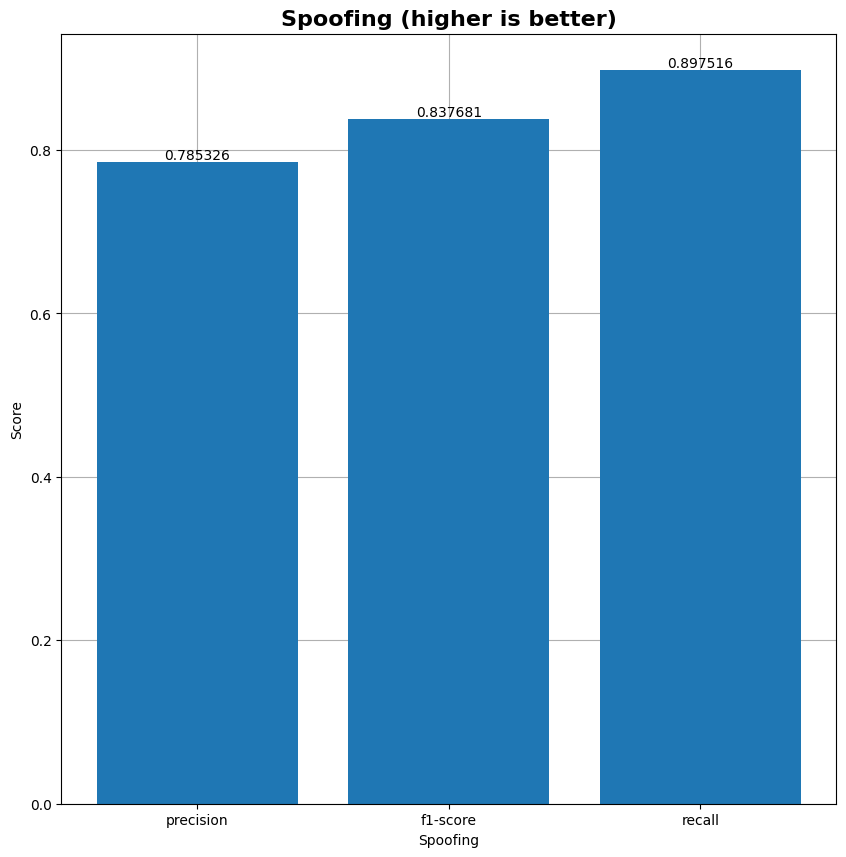

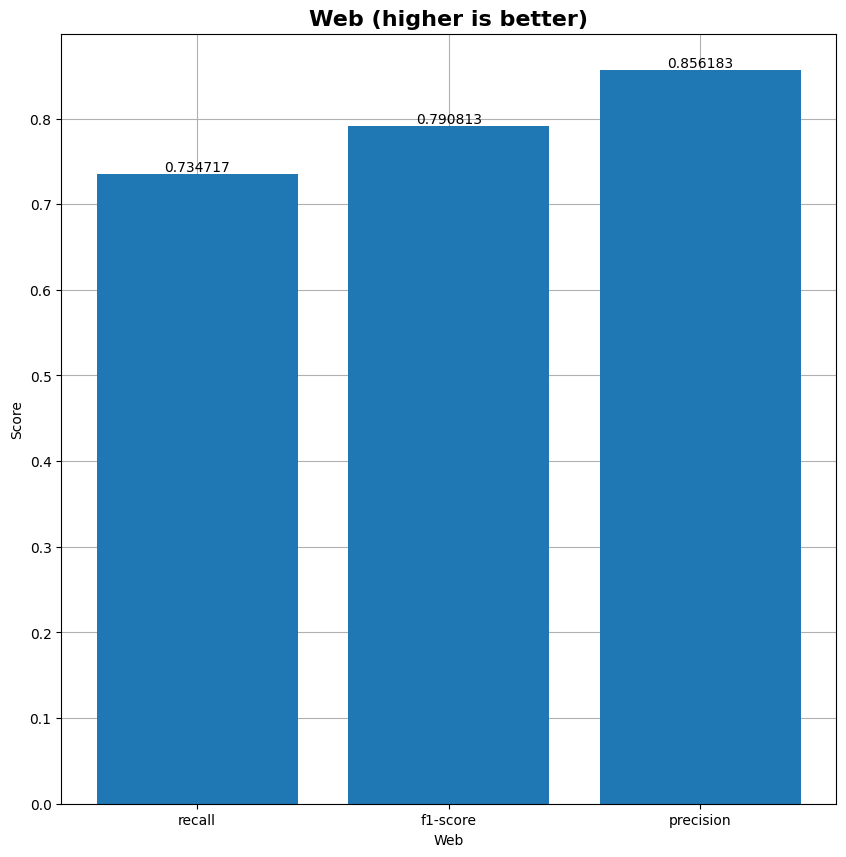

In [48]:
plot_mc(y_pred, y_test, "XGBoost")

In [49]:
model_name = "XGB_5000.sav"
pickle.dump(xgb_clf, open(model_name, 'wb'))

# LightGBM

In [50]:
%%time

start = time.time()

process = psutil.Process()
cpu_before = process.cpu_percent(interval=None)
mem_before = process.memory_info().rss

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)

y_pred = lgbm_clf.predict(X_test)

cpu_after = process.cpu_percent(interval=None)
mem_after = process.memory_info().rss

end = time.time()

LightGBM_Time = end - start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5107
[LightGBM] [Info] Number of data points in the train set: 34000, number of used features: 39
[LightGBM] [Info] Start training from score -2.084395
[LightGBM] [Info] Start training from score -2.081326
[LightGBM] [Info] Start training from score -2.088423
[LightGBM] [Info] Start training from score -2.069608
[LightGBM] [Info] Start training from score -2.081090
[LightGBM] [Info] Start training from score -2.076622
[LightGBM] [Info] Start training from score -2.076153
[LightGBM] [Info] Start training from score -2.078031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: user 9.8 s, sys: 126 ms, total: 9.93 s
Wall time: 2.56 s


/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


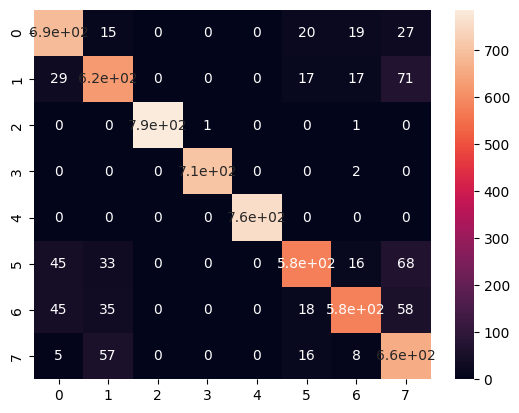

In [51]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [52]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [53]:
latencies = []
for sample in X_test:
    start_time = time.perf_counter()  # Higher precision than time.time()
    _ = lgbm_clf.predict(sample.reshape(1, -1))  # Reshape for single sample
    latencies.append(time.perf_counter() - start_time)
mean_latency = np.mean(latencies) * 1000
std_latency = np.std(latencies) * 1000

print(f"CPU usage: {cpu_after - cpu_before}%")
memory = (mem_after - mem_before) / (1024 * 1024)
print(f"Memory usage: {(mem_after - mem_before) / (1024 * 1024)} MB")
print(f"Memory usage: {(mem_after - mem_before) / (1024)} KB")
print(f"Memory usage: {(mem_after - mem_before)} B")
print(f"Prediction time: {end - start} seconds")

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

CPU usage: 387.6%
Memory usage: 8.1953125 MB
Memory usage: 8392.0 KB
Memory usage: 8593408 B
Prediction time: 2.5620315074920654 seconds


/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

In [54]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, mean_latency, std_latency, memory, LightGBM_Time]
results_dict["XGBoost"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Mean Latency (ms)", "Standard Latency (ms)", "Memory Usage (MB)", "Time"])

In [55]:
results_df

Accuracy  Precision        F1    Recall       MCC       MAE  \
kNN      0.691167   0.697398  0.691055  0.691167  0.647975  1.167833   
LR       0.640000   0.659405  0.640927  0.640000  0.591002  1.278500   
RF       0.877167   0.882256  0.877560  0.877167  0.860233  0.472333   
XGBoost  0.896167   0.900100  0.896406  0.896167  0.881839  0.414000   

              MSE      RMSE  Mean Latency (ms)  Standard Latency (ms)  \
kNN      5.981833  2.445779           2.226666               0.586299   
LR       6.325833  2.515121           0.123944               0.040489   
RF       2.386000  1.544668          26.711837               7.628707   
XGBoost  2.120000  1.456022           1.898904               0.978627   

         Memory Usage (MB)        Time  
kNN              12.328125    0.528861  
LR               18.031250  139.980253  
RF              136.351562    1.787864  
XGBoost           8.195312    2.562032

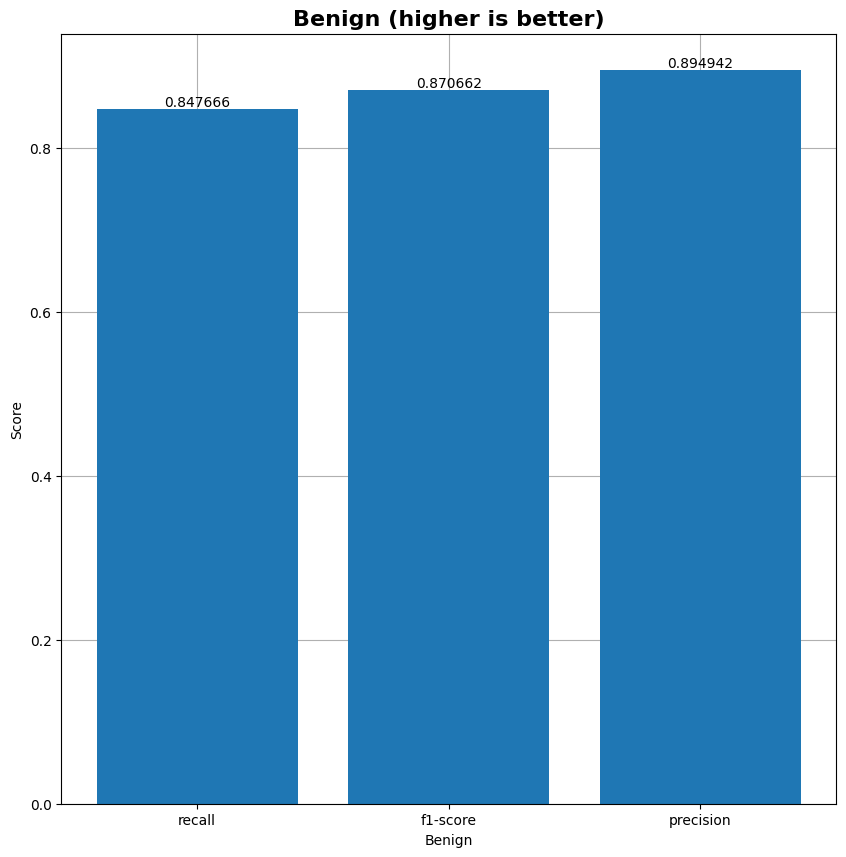

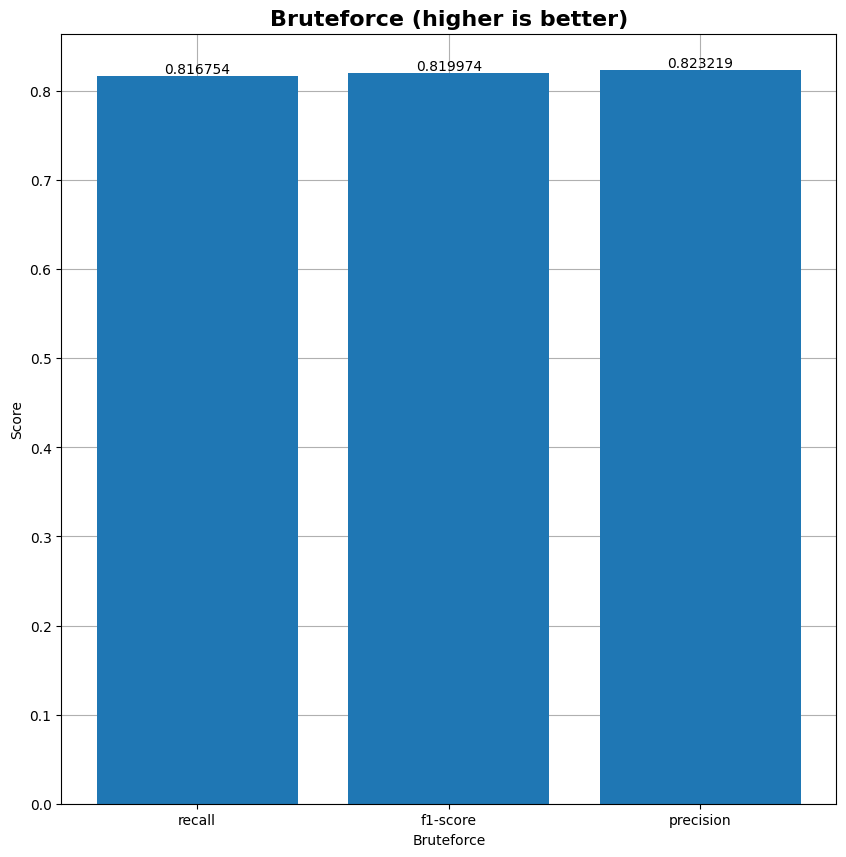

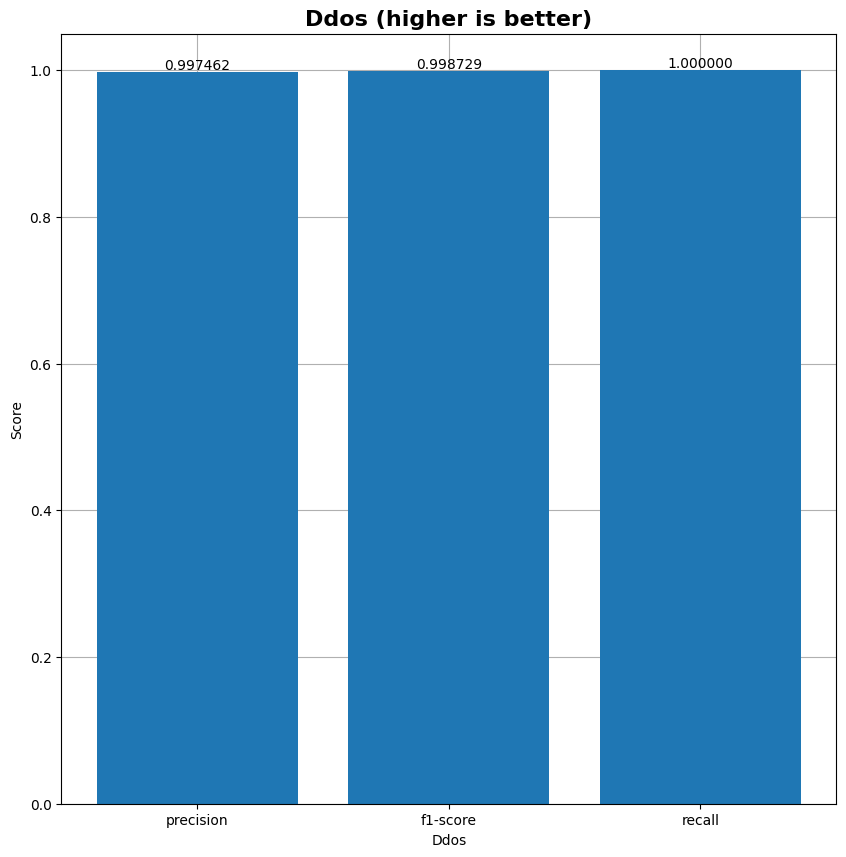

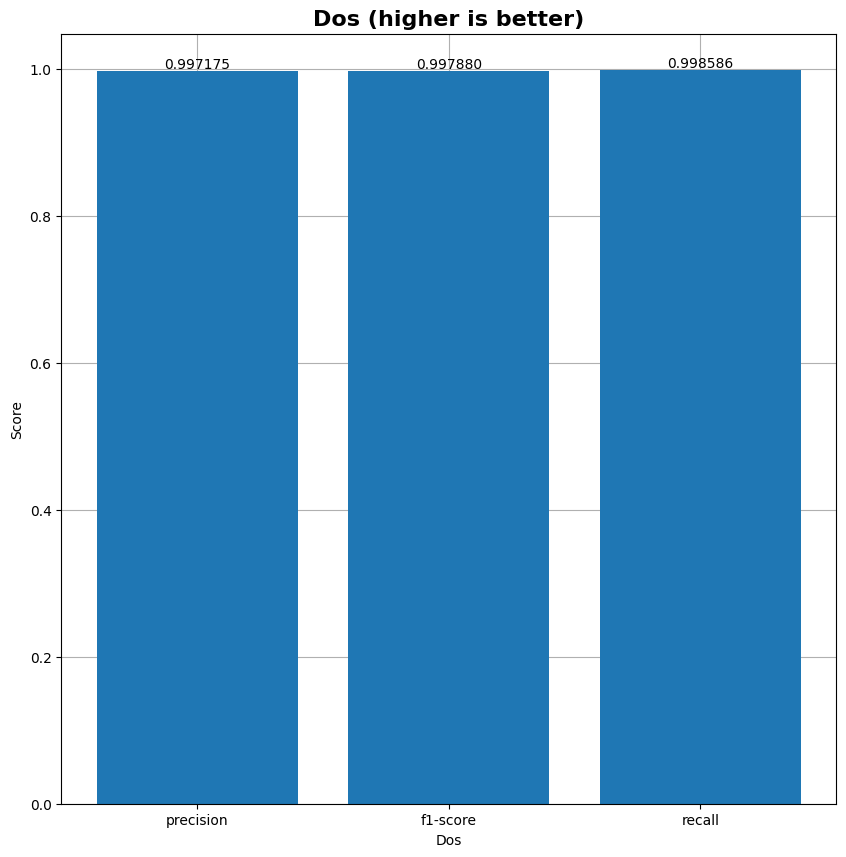

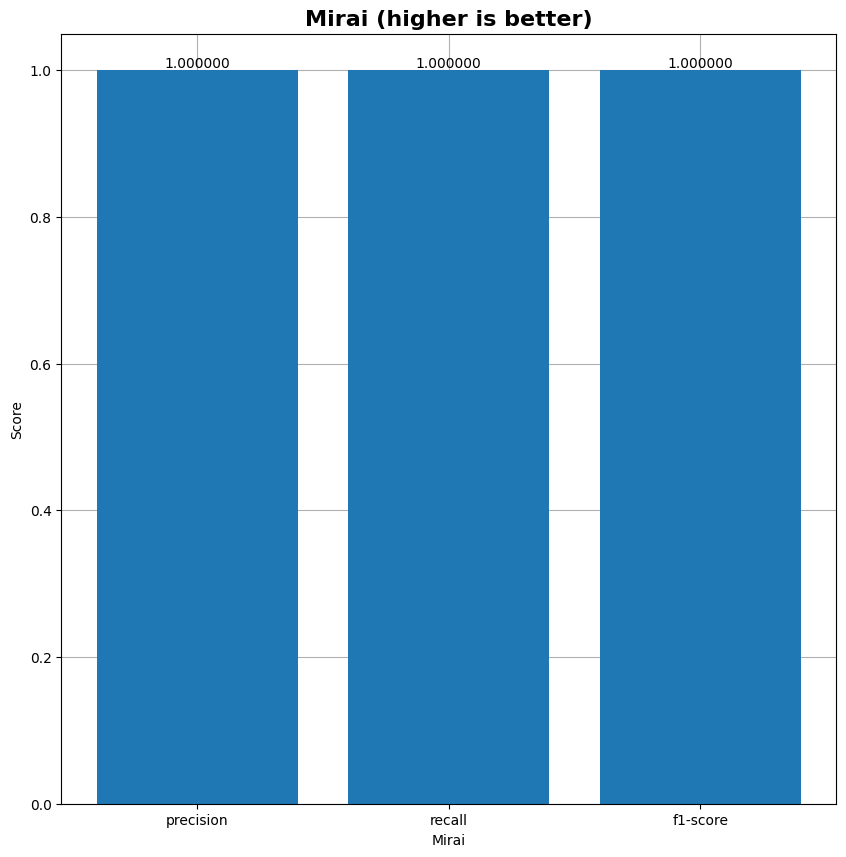

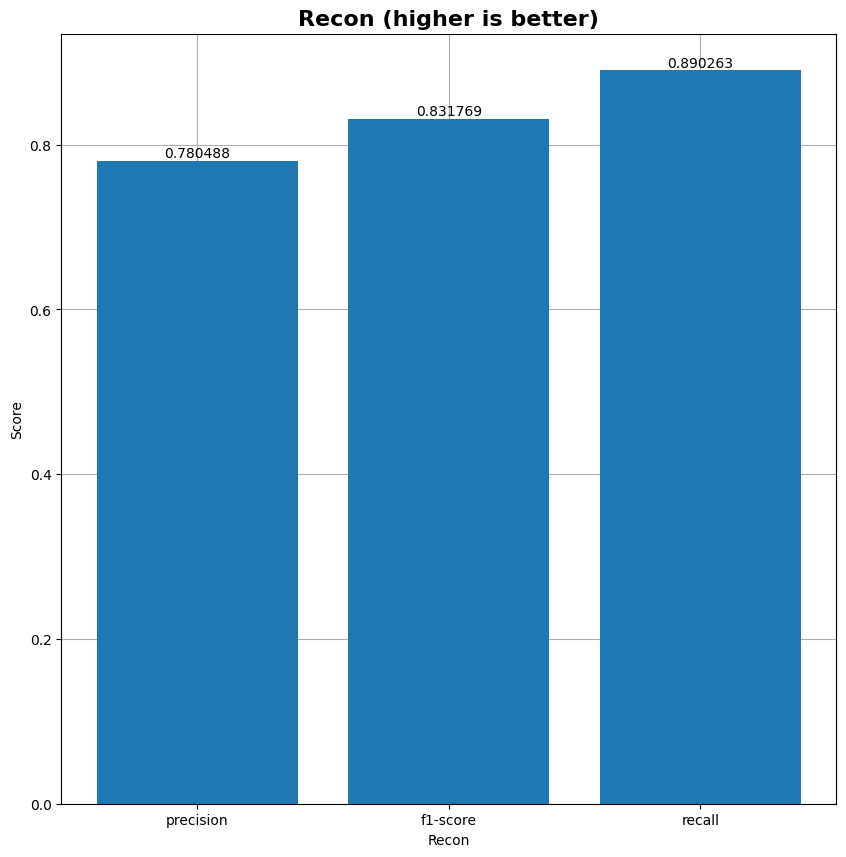

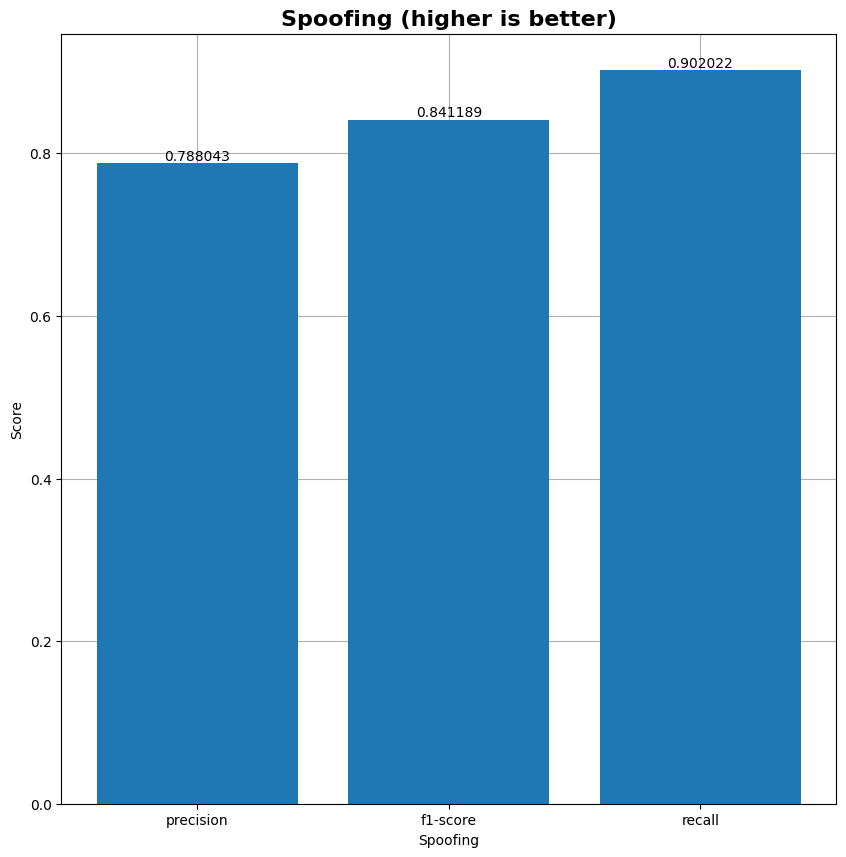

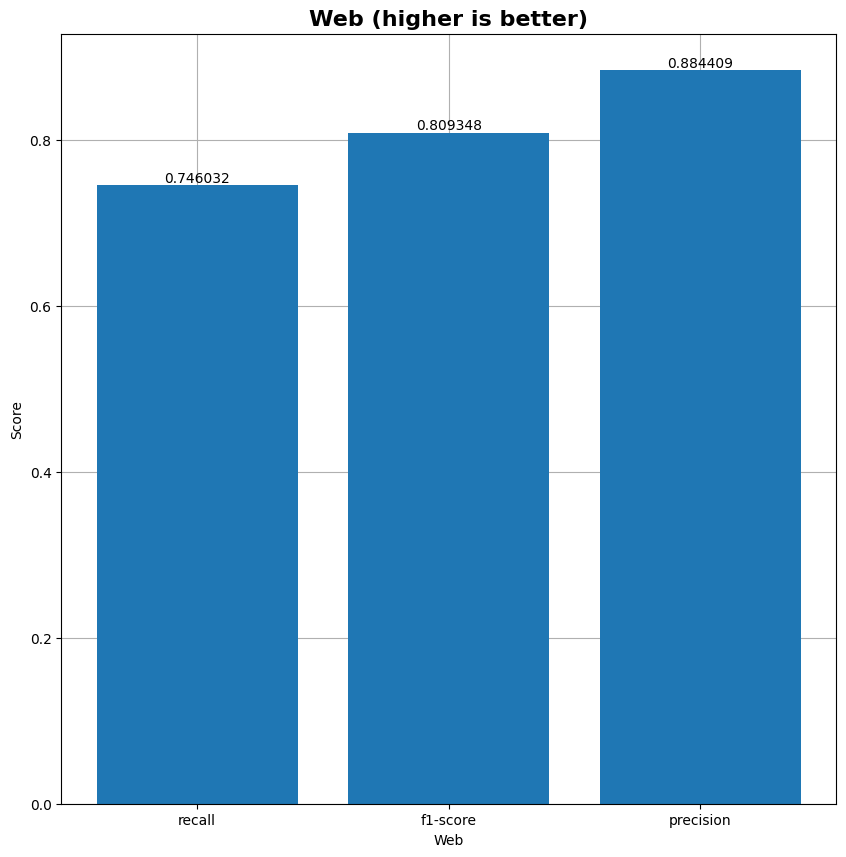

In [56]:
plot_mc(y_pred, y_test, "LightGBM")

In [57]:
model_name = "LightGBM_5000.sav"
pickle.dump(lgbm_clf, open(model_name, 'wb'))

# Support Vector Machine

In [58]:
%%time

start = time.time()

process = psutil.Process()
cpu_before = process.cpu_percent(interval=None)
mem_before = process.memory_info().rss

svm_clf = SVC(kernel = 'poly', C = 1, random_state = 0, probability = True)
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

cpu_after = process.cpu_percent(interval=None)
mem_after = process.memory_info().rss

end = time.time()

SVM_Time = end - start

CPU times: user 5min 6s, sys: 2.08 s, total: 5min 8s
Wall time: 5min 11s


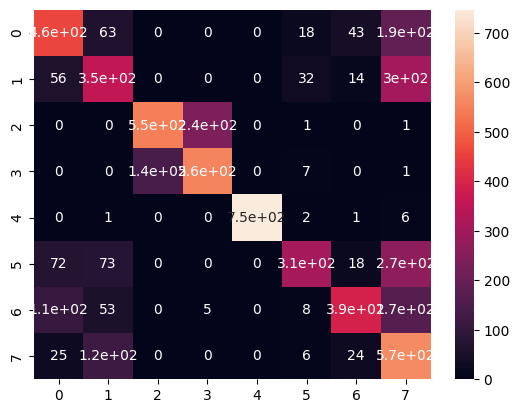

In [59]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [60]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [61]:
latencies = []
for sample in X_test:
    start_time = time.perf_counter()  # Higher precision than time.time()
    _ = svm_clf.predict(sample.reshape(1, -1))  # Reshape for single sample
    latencies.append(time.perf_counter() - start_time)
mean_latency = np.mean(latencies) * 1000
std_latency = np.std(latencies) * 1000

print(f"CPU usage: {cpu_after - cpu_before}%")
memory = (mem_after - mem_before) / (1024 * 1024)
print(f"Memory usage: {(mem_after - mem_before) / (1024 * 1024)} MB")
print(f"Memory usage: {(mem_after - mem_before) / (1024)} KB")
print(f"Memory usage: {(mem_after - mem_before)} B")
print(f"Prediction time: {end - start} seconds")

CPU usage: 99.2%
Memory usage: 103.65625 MB
Memory usage: 106144.0 KB
Memory usage: 108691456 B
Prediction time: 311.28930473327637 seconds


In [62]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, mean_latency, std_latency, memory, SVM_Time]
results_dict["SVM"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Mean Latency (ms)", "Standard Latency (ms)", "Memory Usage (MB)", "Time"])

In [63]:
results_df

Accuracy  Precision        F1    Recall       MCC       MAE  \
kNN      0.691167   0.697398  0.691055  0.691167  0.647975  1.167833   
LR       0.640000   0.659405  0.640927  0.640000  0.591002  1.278500   
RF       0.877167   0.882256  0.877560  0.877167  0.860233  0.472333   
XGBoost  0.896167   0.900100  0.896406  0.896167  0.881839  0.414000   
SVM      0.655833   0.705602  0.660756  0.655833  0.614441  1.244000   

              MSE      RMSE  Mean Latency (ms)  Standard Latency (ms)  \
kNN      5.981833  2.445779           2.226666               0.586299   
LR       6.325833  2.515121           0.123944               0.040489   
RF       2.386000  1.544668          26.711837               7.628707   
XGBoost  2.120000  1.456022           1.898904               0.978627   
SVM      6.445000  2.538700           1.396294               0.297618   

         Memory Usage (MB)        Time  
kNN              12.328125    0.528861  
LR               18.031250  139.980253  
RF              136.351562    1.787864  
XGBoost           8.195312    2.562032  
SVM             103.656250  311.289305

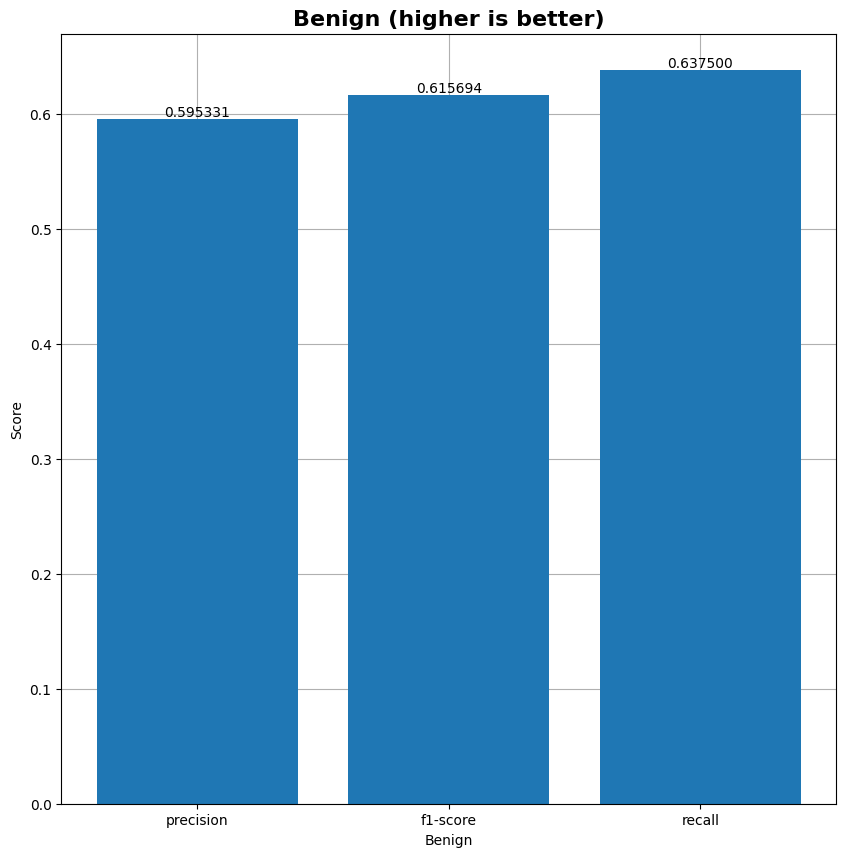

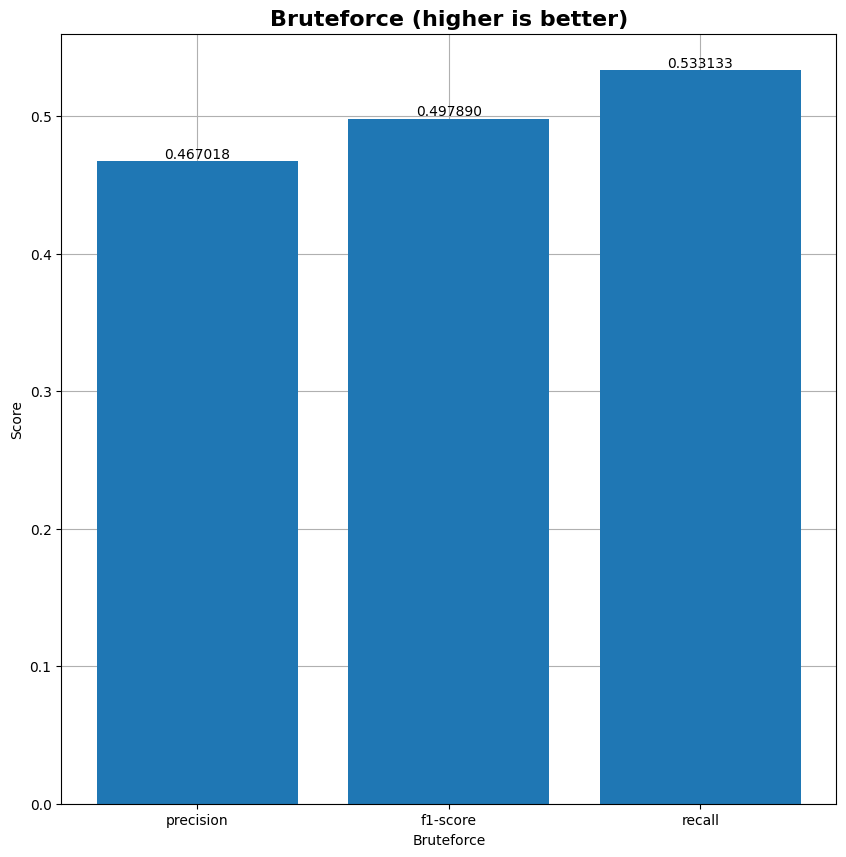

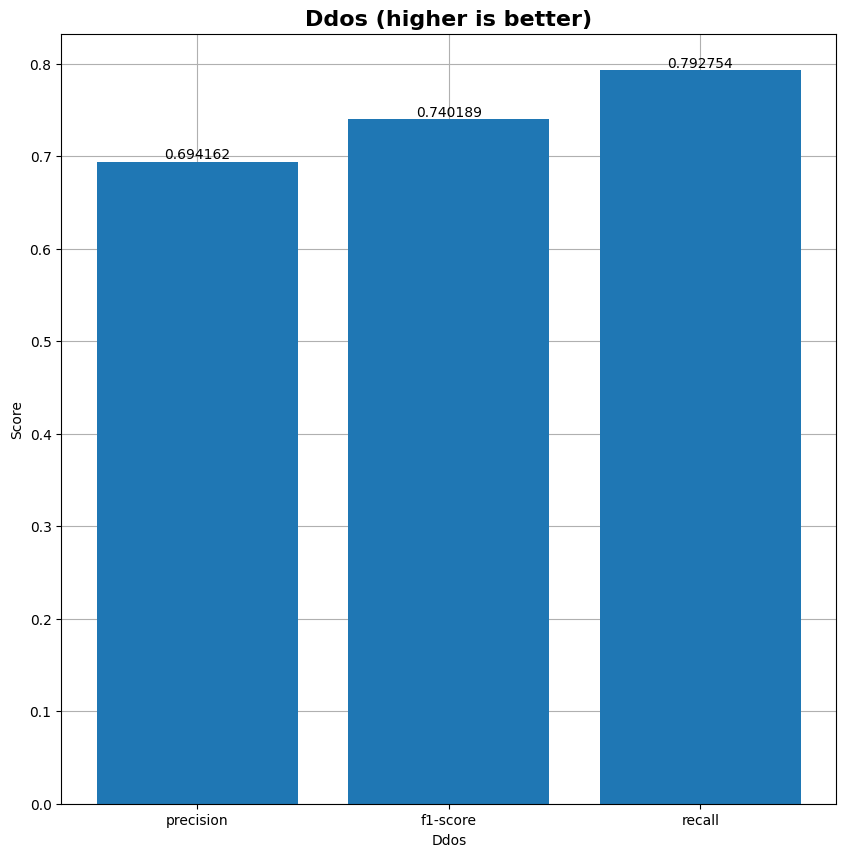

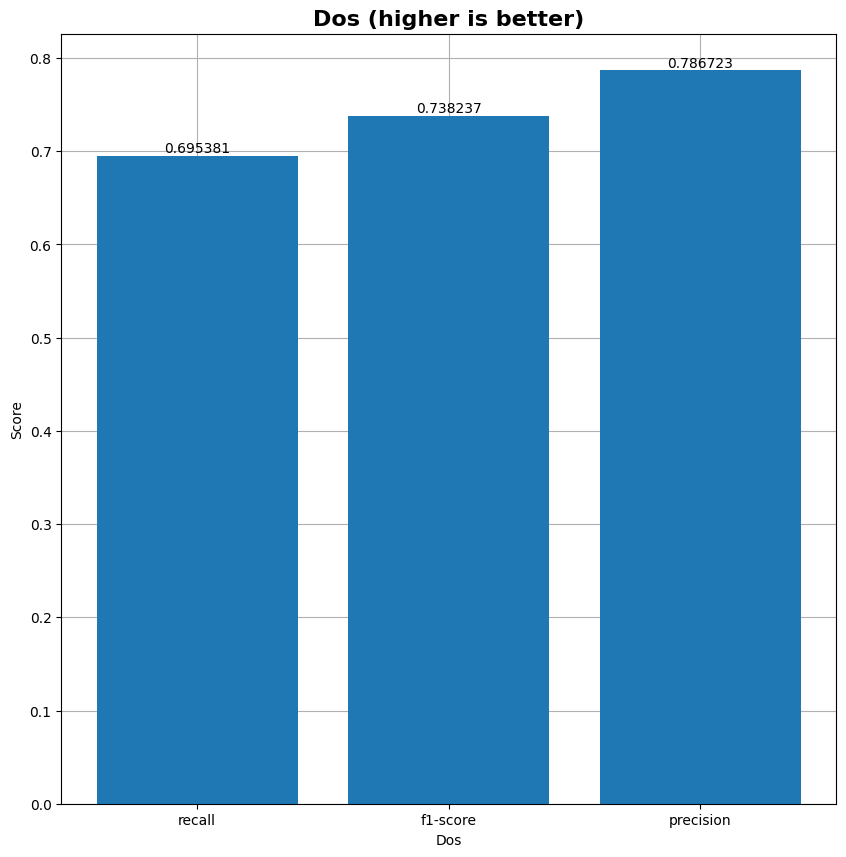

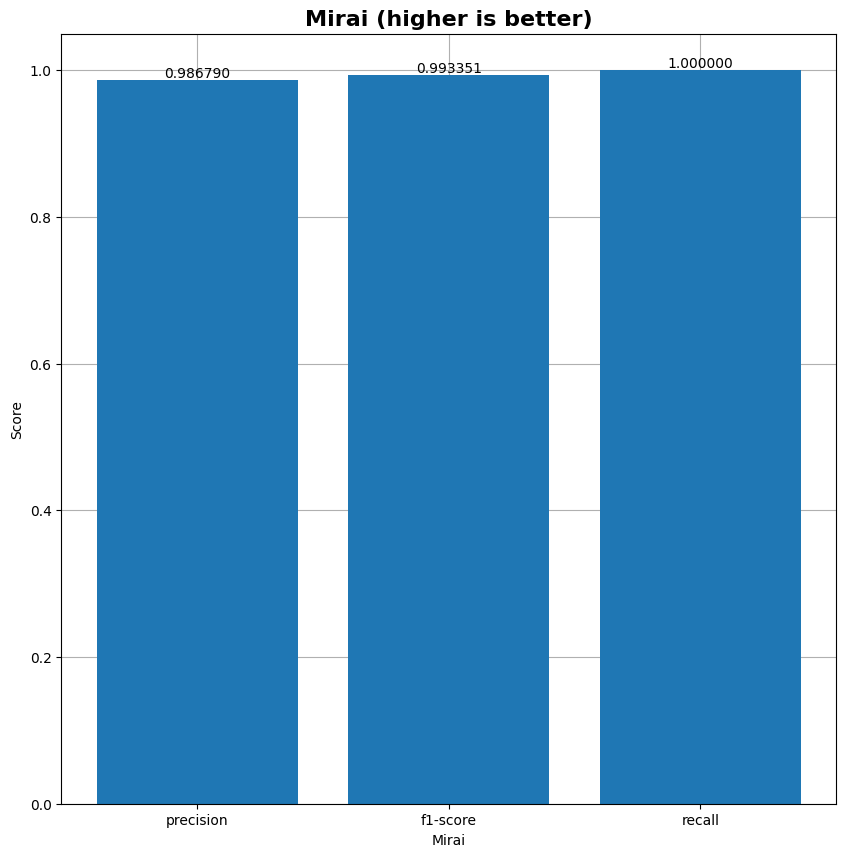

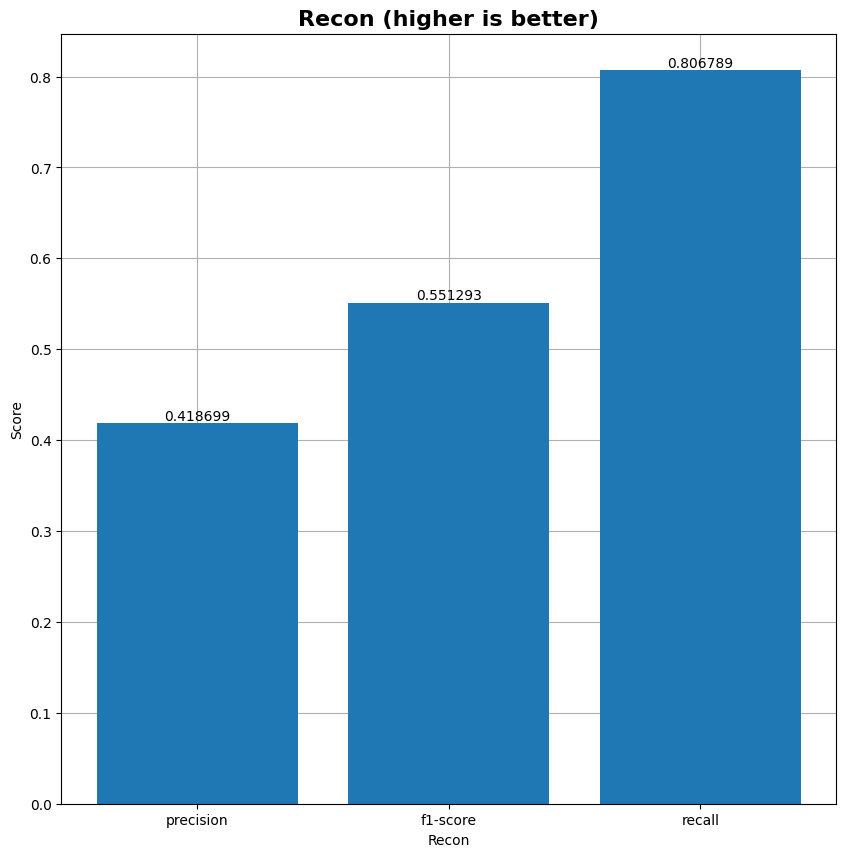

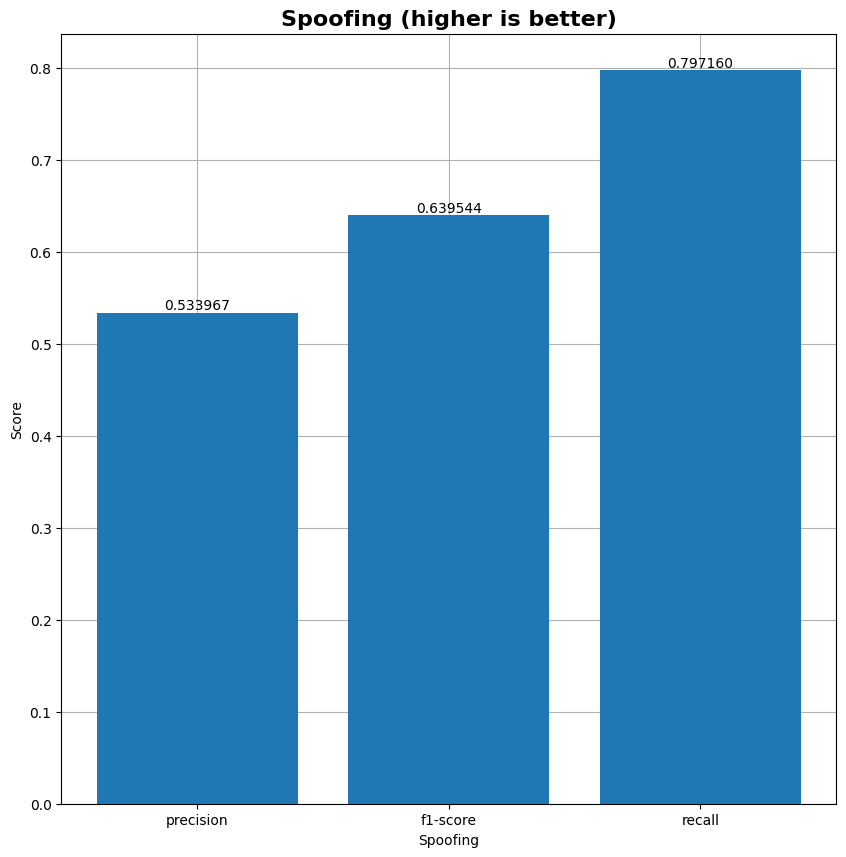

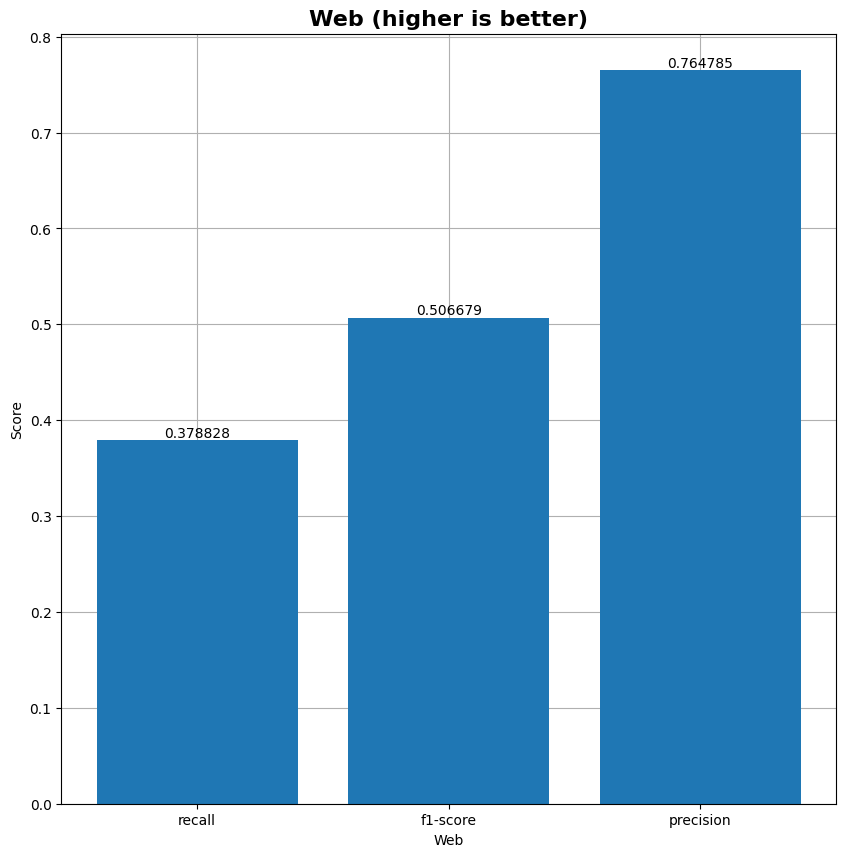

In [64]:
plot_mc(y_pred, y_test, "SVM")

In [65]:
model_name = "SVM_5000.sav"
pickle.dump(svm_clf, open(model_name, 'wb'))

# Feed Forward Neural Network

In [66]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

data['Attack Number'] = le.fit_transform(y)
y = data['Attack Number']

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((27880, 47), (27880,), (6120, 47), (6120,), (6000, 47), (6000,))

In [68]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745426667.504933   22794 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5161 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


In [69]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 47)             │         2,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │        49,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 580,312 (2.21 MB)

 Trainable params: 580,312 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
%%time

start = time.time()

process = psutil.Process()
cpu_before = process.cpu_percent(interval=None)
mem_before = process.memory_info().rss

model.fit(X_train, y_train,
          batch_size=16,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

y_pred = model.predict(X_test)

cpu_after = process.cpu_percent(interval=None)
mem_after = process.memory_info().rss

end = time.time()

FFNN_Time = end - start

Epoch 1/20


I0000 00:00:1745426669.477179  102363 service.cc:152] XLA service 0x70602400acd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745426669.477194  102363 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2025-04-23 19:44:29.516228: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745426669.758443  102363 cuda_dnn.cc:529] Loaded cuDNN version 90300


  61/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4633 - loss: 1.4453    

I0000 00:00:1745426670.815067  102363 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1743/1743 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8473 - loss: 0.4276 - val_accuracy: 0.9810 - val_loss: 0.0619
Epoch 2/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9830 - loss: 0.0539 - val_accuracy: 0.9900 - val_loss: 0.0341
Epoch 3/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9907 - loss: 0.0411 - val_accuracy: 0.9959 - val_loss: 0.0103
Epoch 4/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9908 - loss: 0.0397 - val_accuracy: 0.9925 - val_loss: 0.0222
Epoch 5/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9958 - loss: 0.0140 - val_accuracy: 0.9972 - val_loss: 0.0097
Epoch 6/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9929 - loss: 0.0191 - val_accuracy: 0.9961 - val_loss: 0.0106
Epoch 7/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9947 - loss: 0.0165 - val_accuracy: 0.9956 - val_loss: 0.0209
Epoch 8/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9943 - loss: 0.0184 - val_accurac

In [71]:
y_pred = np.argmax(y_pred, axis=1)

In [72]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9944 - loss: 0.0177       


In [73]:
latencies = []
for sample in X_test:
    start_time = time.perf_counter()  # Higher precision than time.time()
    _ = model.predict(sample.reshape(1, -1))  # Reshape for single sample
    latencies.append(time.perf_counter() - start_time)
mean_latency = np.mean(latencies) * 1000
std_latency = np.std(latencies) * 1000

print(f"CPU usage: {cpu_after - cpu_before}%")
memory = (mem_after - mem_before) / (1024 * 1024)
print(f"Memory usage: {(mem_after - mem_before) / (1024 * 1024)} MB")
print(f"Memory usage: {(mem_after - mem_before) / (1024)} KB")
print(f"Memory usage: {(mem_after - mem_before)} B")
print(f"Prediction time: {end - start} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

In [74]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, mean_latency, std_latency, memory, FFNN_Time]
results_dict["FF-NN"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Mean Latency (ms)", "Standard Latency (ms)", "Memory Usage (MB)", "Time"])

In [75]:
results_df

Accuracy  Precision        F1    Recall       MCC       MAE  \
kNN      0.691167   0.697398  0.691055  0.691167  0.647975  1.167833   
LR       0.640000   0.659405  0.640927  0.640000  0.591002  1.278500   
RF       0.877167   0.882256  0.877560  0.877167  0.860233  0.472333   
XGBoost  0.896167   0.900100  0.896406  0.896167  0.881839  0.414000   
SVM      0.655833   0.705602  0.660756  0.655833  0.614441  1.244000   
FF-NN    0.995833   0.995857  0.995834  0.995833  0.995241  0.004333   

              MSE      RMSE  Mean Latency (ms)  Standard Latency (ms)  \
kNN      5.981833  2.445779           2.226666               0.586299   
LR       6.325833  2.515121           0.123944               0.040489   
RF       2.386000  1.544668          26.711837               7.628707   
XGBoost  2.120000  1.456022           1.898904               0.978627   
SVM      6.445000  2.538700           1.396294               0.297618   
FF-NN    0.004667  0.068313          74.199061              13.517083   

         Memory Usage (MB)        Time  
kNN              12.328125    0.528861  
LR               18.031250  139.980253  
RF              136.351562    1.787864  
XGBoost           8.195312    2.562032  
SVM             103.656250  311.289305  
FF-NN            35.691406  103.317089

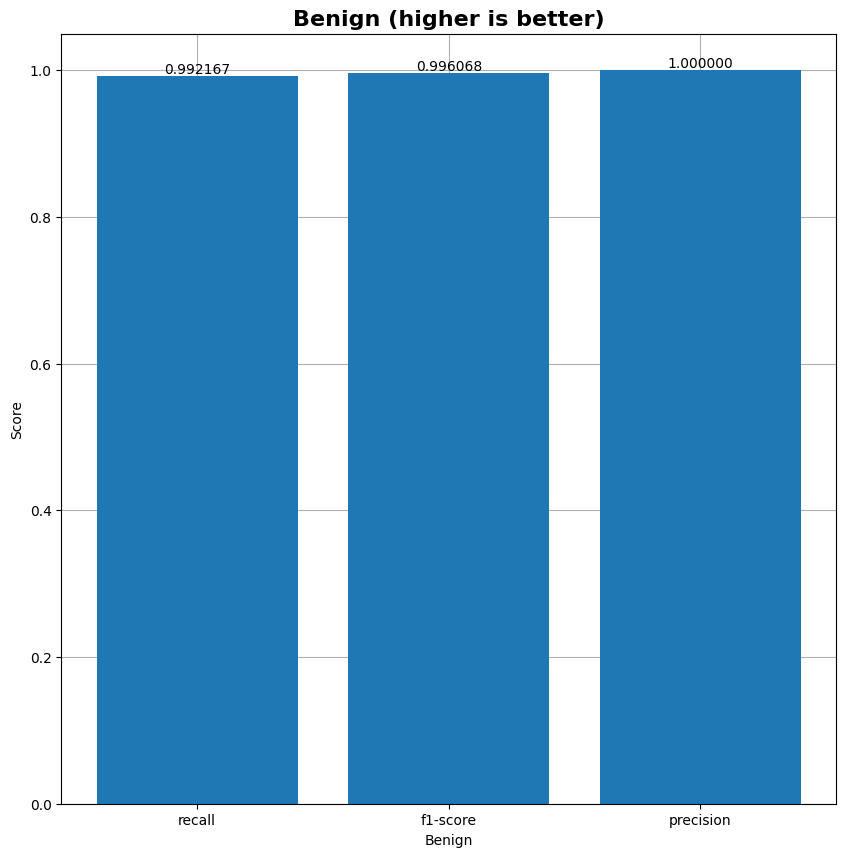

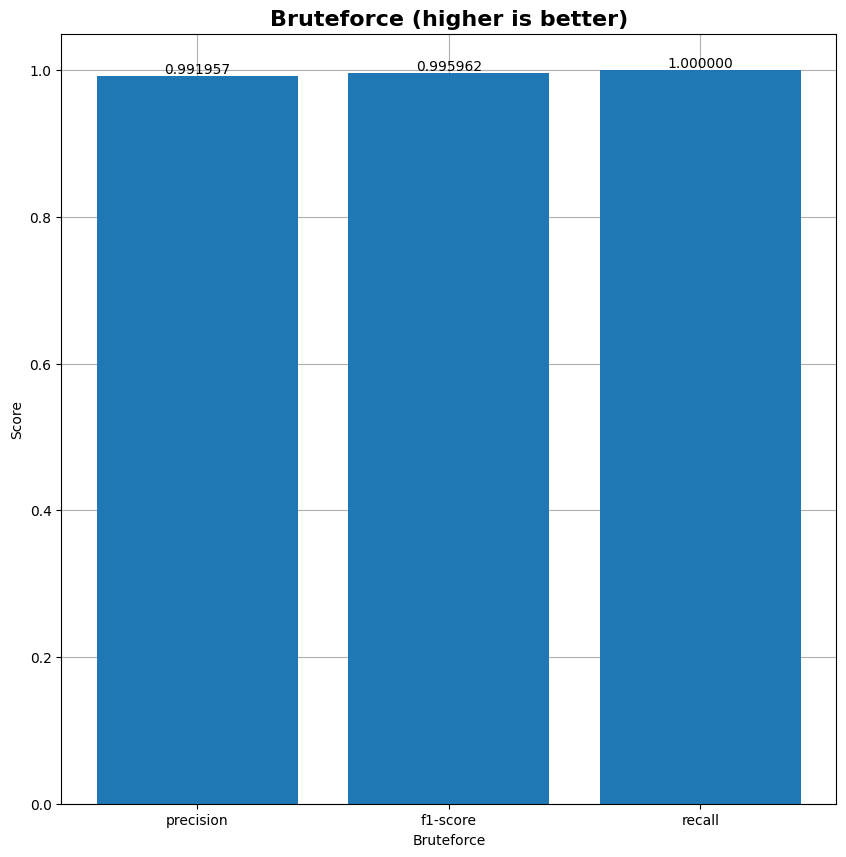

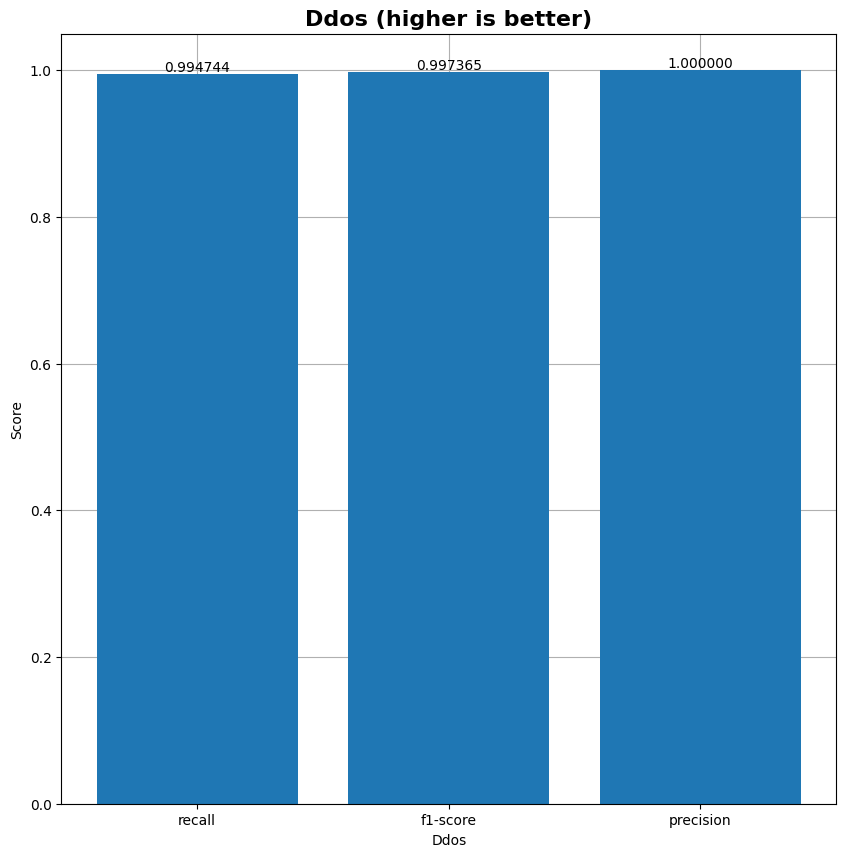

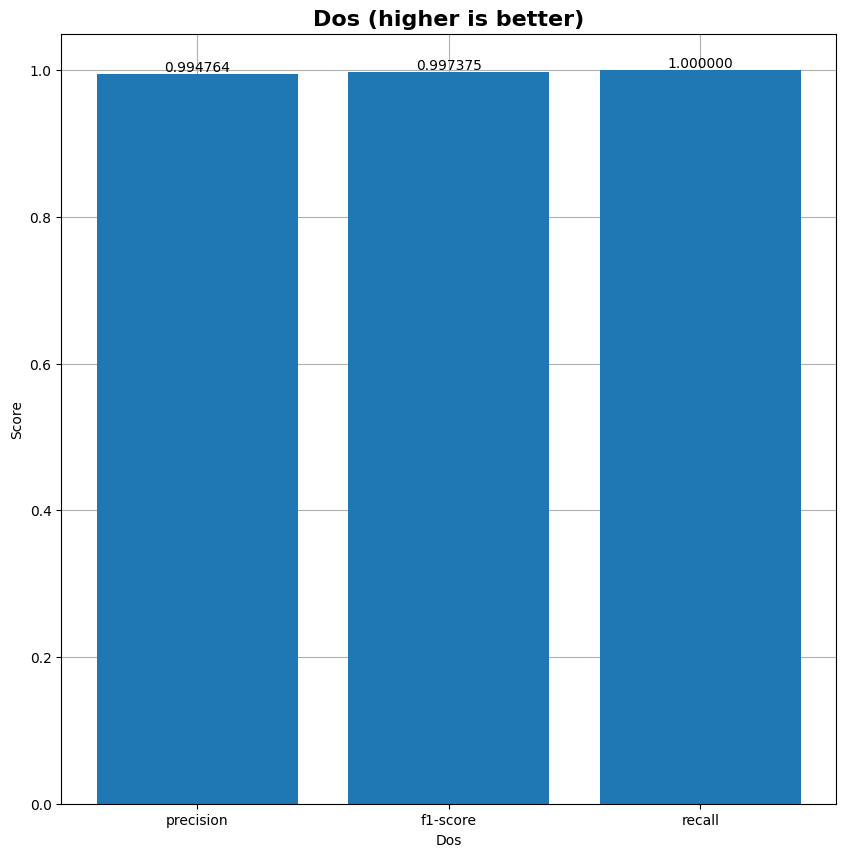

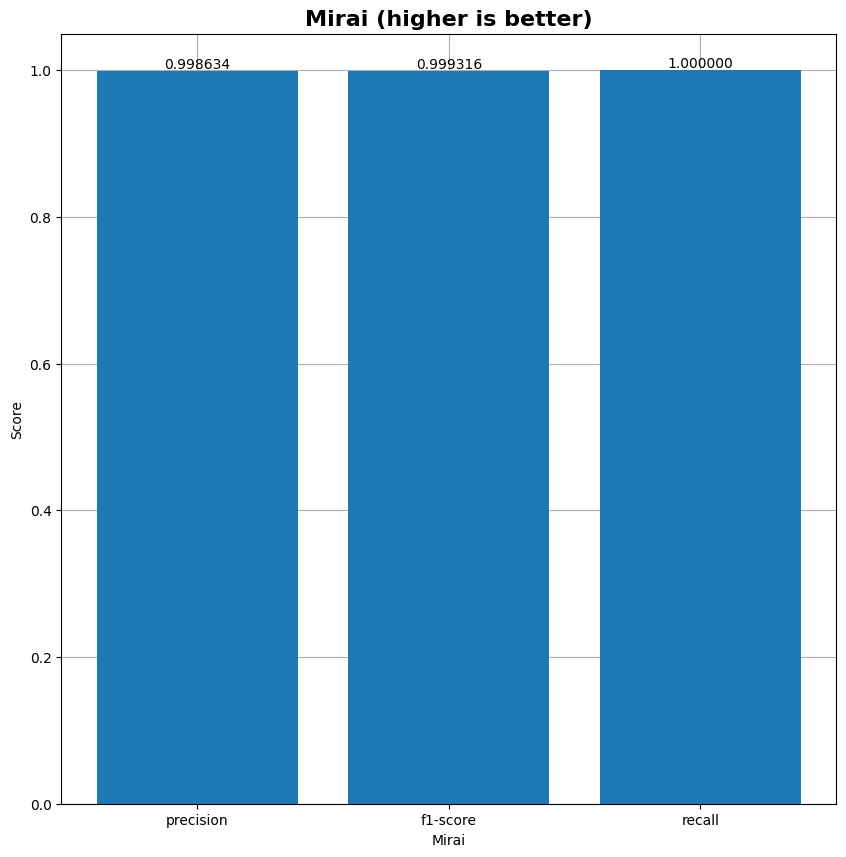

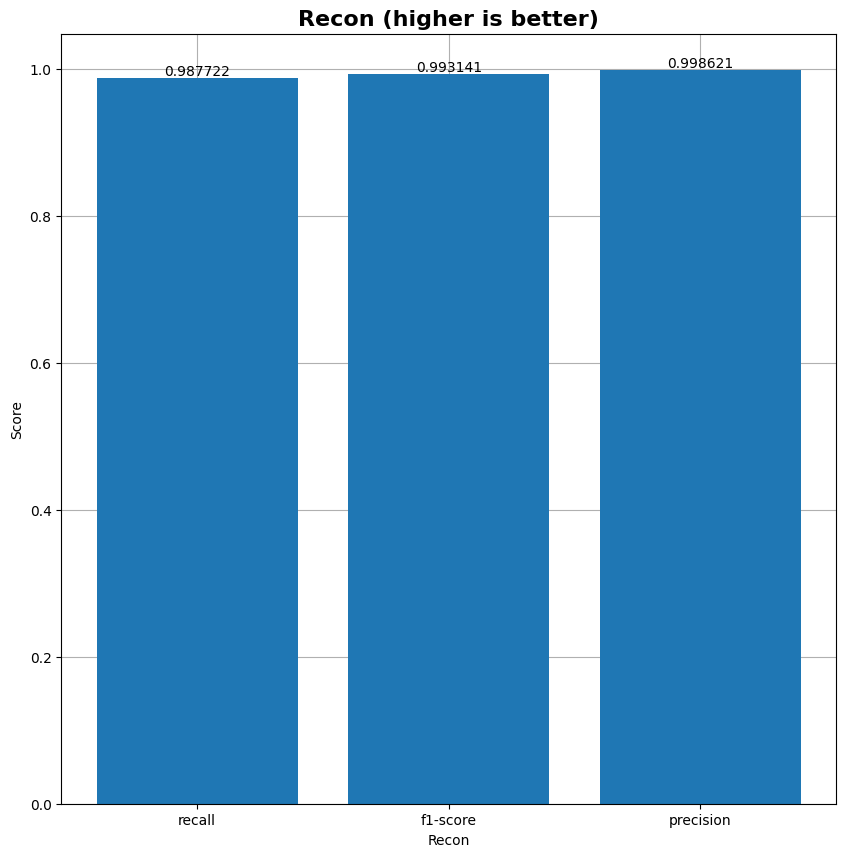

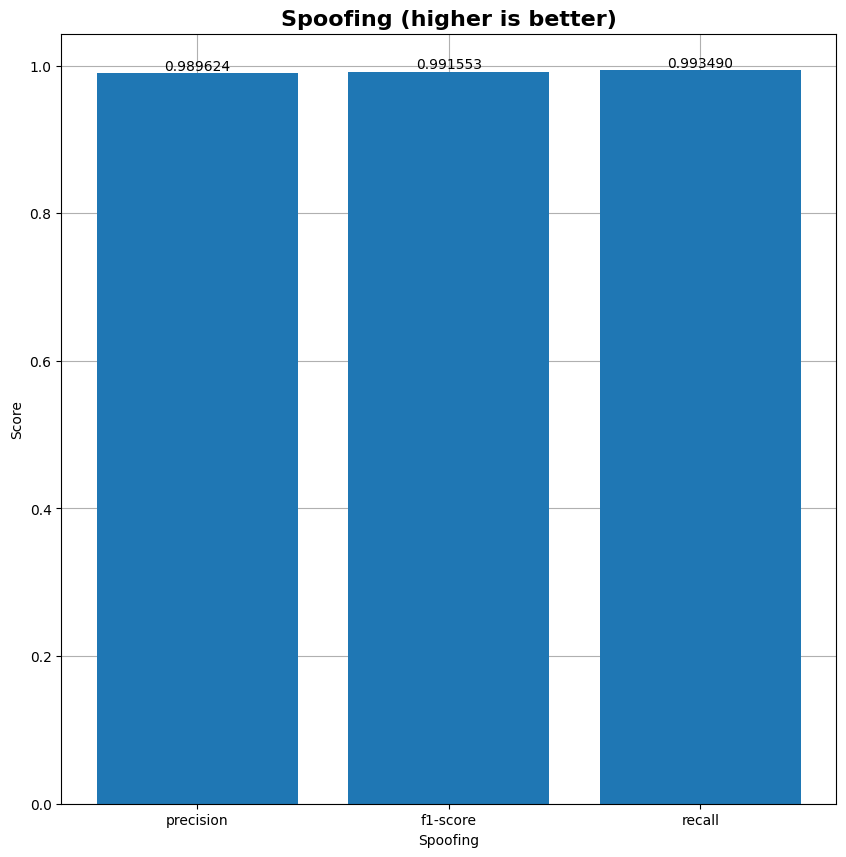

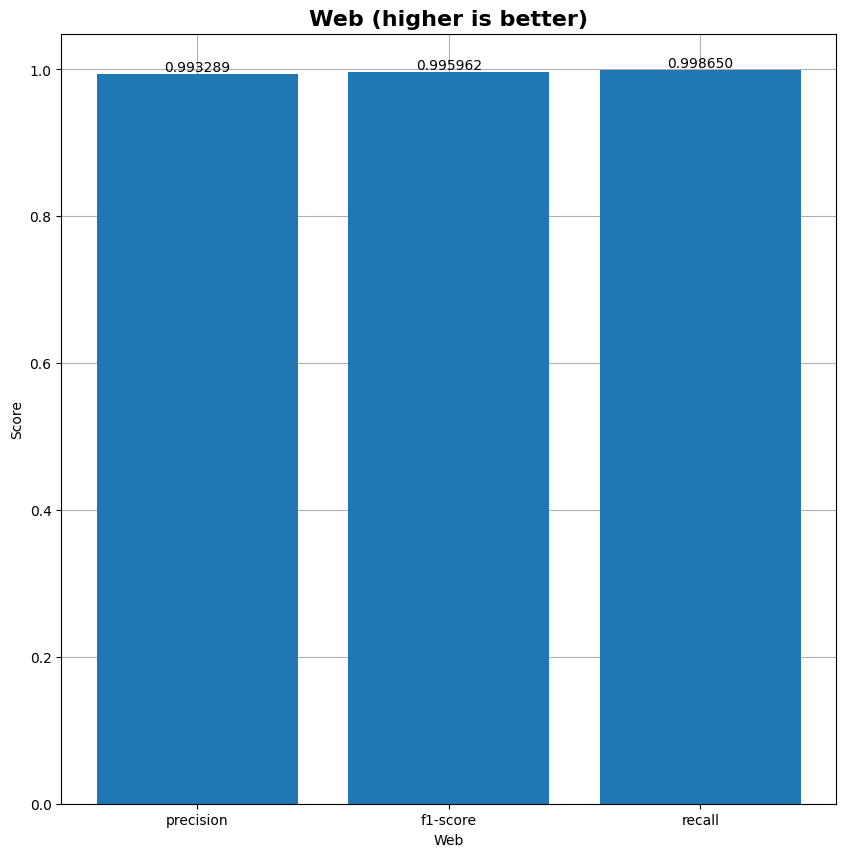

In [76]:
plot_mc(y_pred, y_test, "FF-NN")

model_name = "FFNN_5000.sav"
pickle.dump(model, open(model_name, 'wb'))

# LSTM

In [77]:
# Prepare sequential data
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Use the last label in the sequence
    return np.array(sequences), np.array(seq_labels)

In [78]:
num_components = len(np.unique(y))

In [79]:
# Create sequences
seq_length = 20
X1, y1 = create_sequences(X, y, seq_length)
y1 = to_categorical(y1, num_classes=num_components)  # Convert labels to one-hot encoding

In [80]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [81]:
def create_model_LSTM(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [82]:
# Build model
model = create_model_LSTM(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [83]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        28,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,720 (170.78 KB)

 Trainable params: 43,720 (170.78 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
%%time

start = time.time()

process = psutil.Process()
cpu_before = process.cpu_percent(interval=None)
mem_before = process.memory_info().rss

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

cpu_after = process.cpu_percent(interval=None)
mem_after = process.memory_info().rss

end = time.time()

LSTM_Time = end - start

Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9346 - loss: 0.3397 - val_accuracy: 0.9992 - val_loss: 0.0059
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9990 - loss: 0.0077 - val_accuracy: 0.9995 - val_loss: 0.0029
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9992 - loss: 0.0046 - val_accuracy: 0.9997 - val_loss: 0.0030
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9989 - loss: 0.0053 - val_accuracy: 0.9988 - val_loss: 0.0052
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9993 - loss: 0.0031 - val_accuracy: 0.9997 - val_loss: 0.0029
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9997 - val_loss: 0.0033
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9996 - loss: 0.0028 - val_accuracy: 0.9995 - val_loss: 0.0028
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9994 - loss: 0.0017 - val_accuracy:

In [85]:
_, accuracy = model.evaluate(X_test, y_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9997 - loss: 9.5188e-04 


In [86]:
%%time

start_time = time.perf_counter()

model.evaluate(X_test, y_test)

end_time = time.perf_counter()

mean_latency = (end_time - start_time) / X_test.shape[0] * 1000
std_latency = mean_latency

print(f"CPU usage: {cpu_after - cpu_before}%")
memory = (mem_after - mem_before) / (1024 * 1024)
print(f"Memory usage: {(mem_after - mem_before) / (1024 * 1024)} MB")
print(f"Memory usage: {(mem_after - mem_before) / (1024)} KB")
print(f"Memory usage: {(mem_after - mem_before)} B")
print(f"Prediction time: {end - start} seconds")

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9997 - loss: 9.5188e-04 
CPU usage: 132.7%
Memory usage: 146.54296875 MB
Memory usage: 150060.0 KB
Memory usage: 153661440 B
Prediction time: 87.6118733882904 seconds
CPU times: user 1.19 s, sys: 120 ms, total: 1.31 s
Wall time: 944 ms


In [87]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [88]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [89]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, mean_latency, std_latency, memory, LSTM_Time]
results_dict["LSTM"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Mean Latency (ms)", "Standard Latency (ms)", "Memory Usage (MB)", "Time"])

In [90]:
%store results_dict

Stored 'results_dict' (dict)


In [91]:
%store -r results_dict

In [92]:
pip install pickleshare

Note: you may need to restart the kernel to use updated packages.


In [93]:
print(results_dict)

{'kNN': [0.6911666666666667, 0.6973980933427888, 0.6910552758899006, 0.6911666666666667, np.float64(0.6479749251179561), 1.1678333333333333, 5.981833333333333, 2.445778676277421, np.float64(2.226666439002126), np.float64(0.5862993264142293), 12.328125, 0.5288612842559814], 'LR': [0.64, 0.6594050267624378, 0.6409274077700428, 0.64, np.float64(0.5910016468363113), 1.2785, 6.325833333333334, 2.515120938112785, np.float64(0.12394430983401131), np.float64(0.04048872688392046), 18.03125, 139.98025250434875], 'RF': [0.8771666666666667, 0.8822562105279621, 0.8775597845996769, 0.8771666666666667, np.float64(0.8602334394233159), 0.4723333333333333, 2.386, 1.5446682491719703, np.float64(26.711837236667634), np.float64(7.628707006939074), 136.3515625, 1.7878637313842773], 'XGBoost': [0.8961666666666667, 0.9000996641415778, 0.8964057125133108, 0.8961666666666667, np.float64(0.8818386999609332), 0.414, 2.12, 1.4560219778561037, np.float64(1.8989037706681227), np.float64(0.9786269690620409), 8.195312

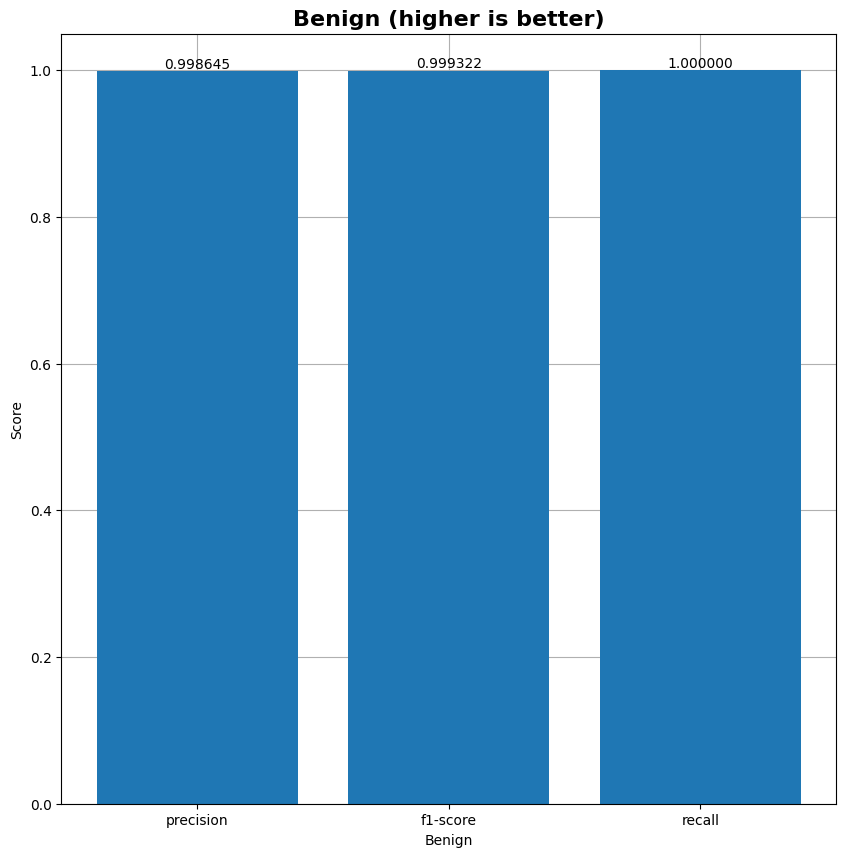

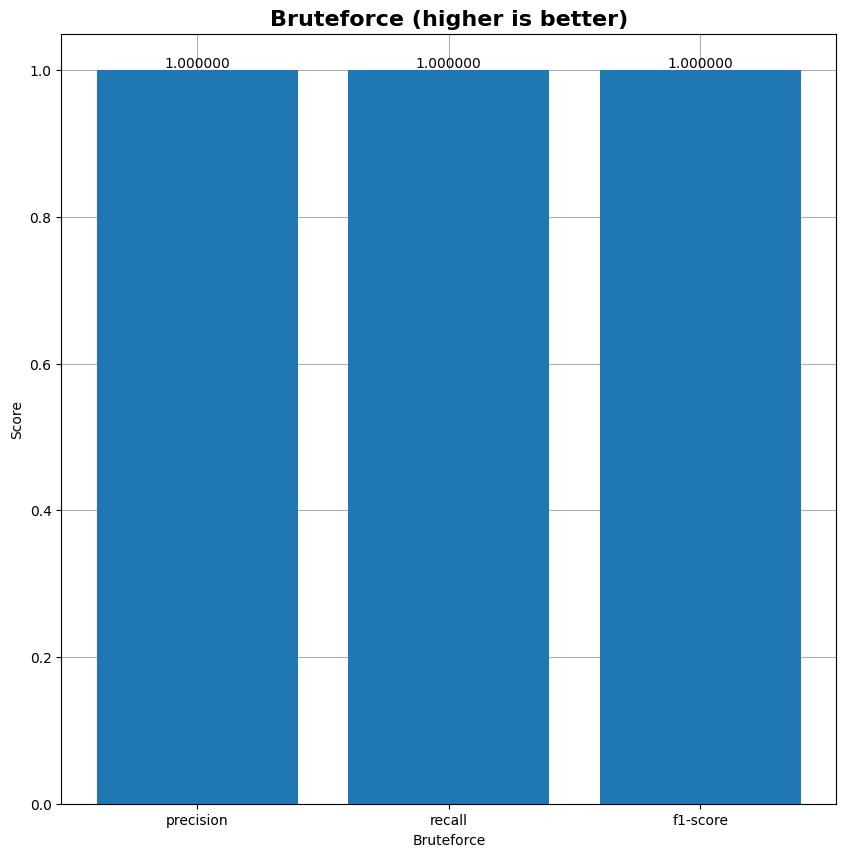

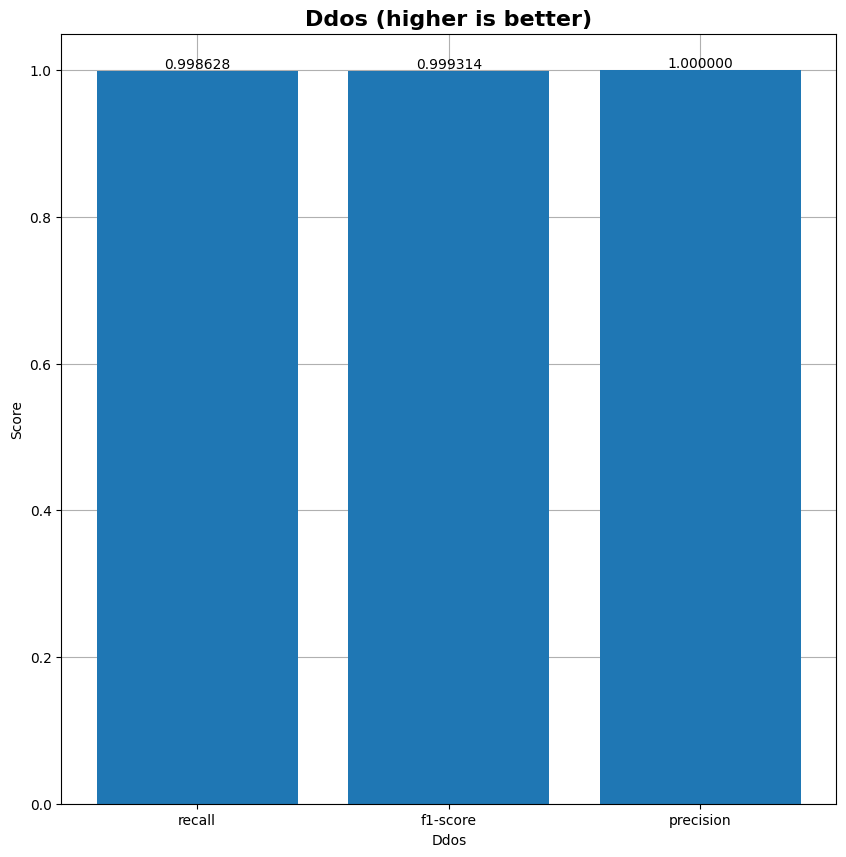

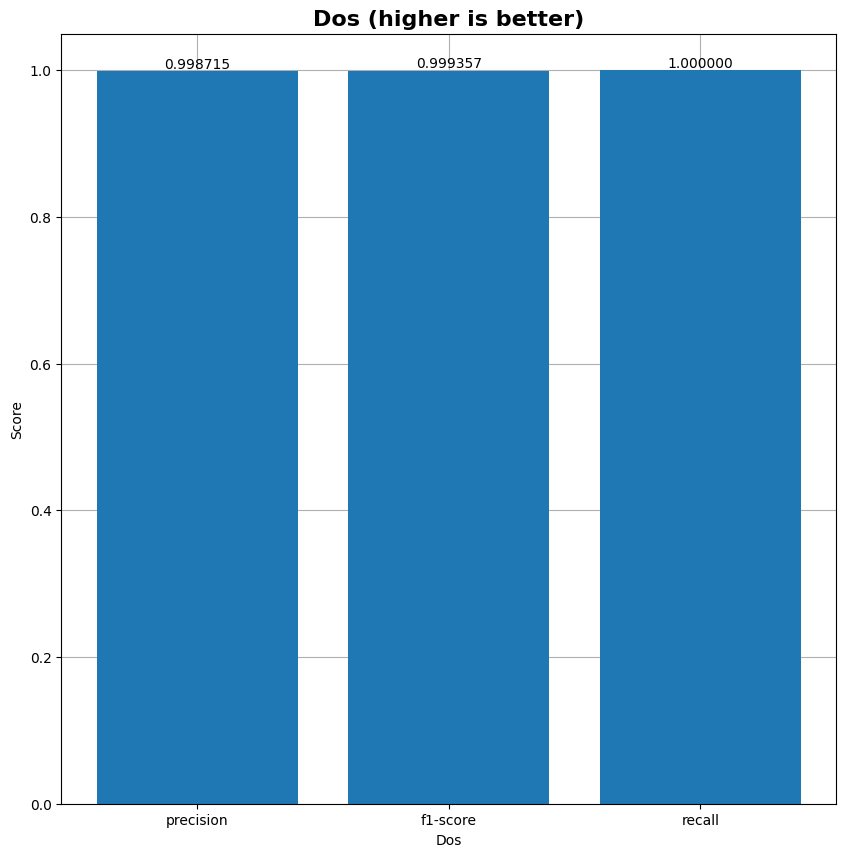

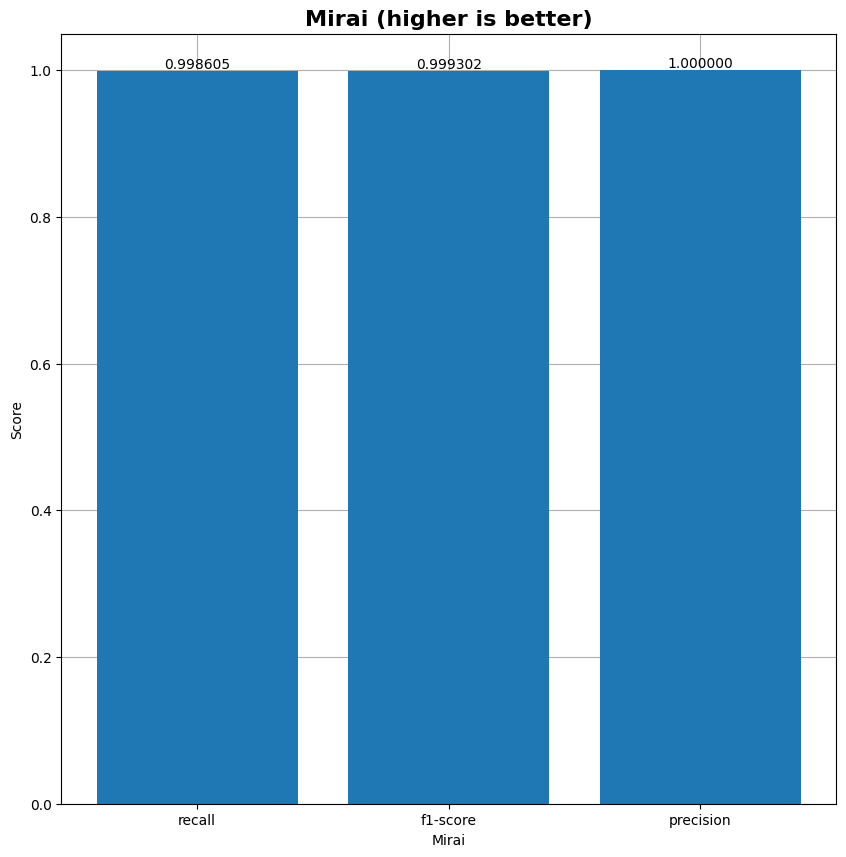

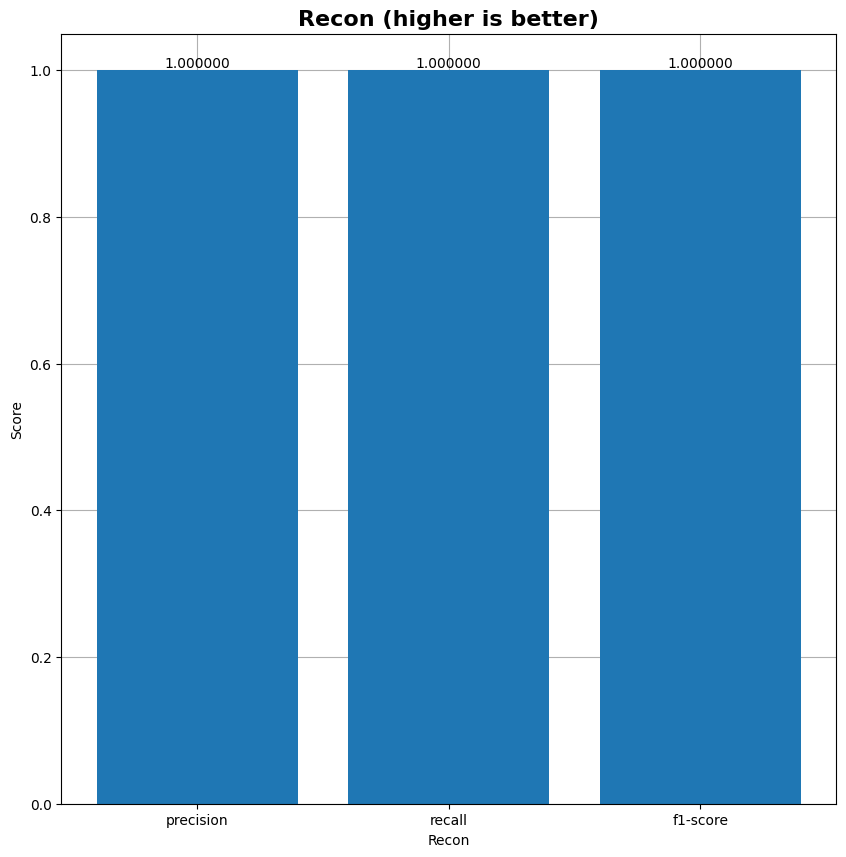

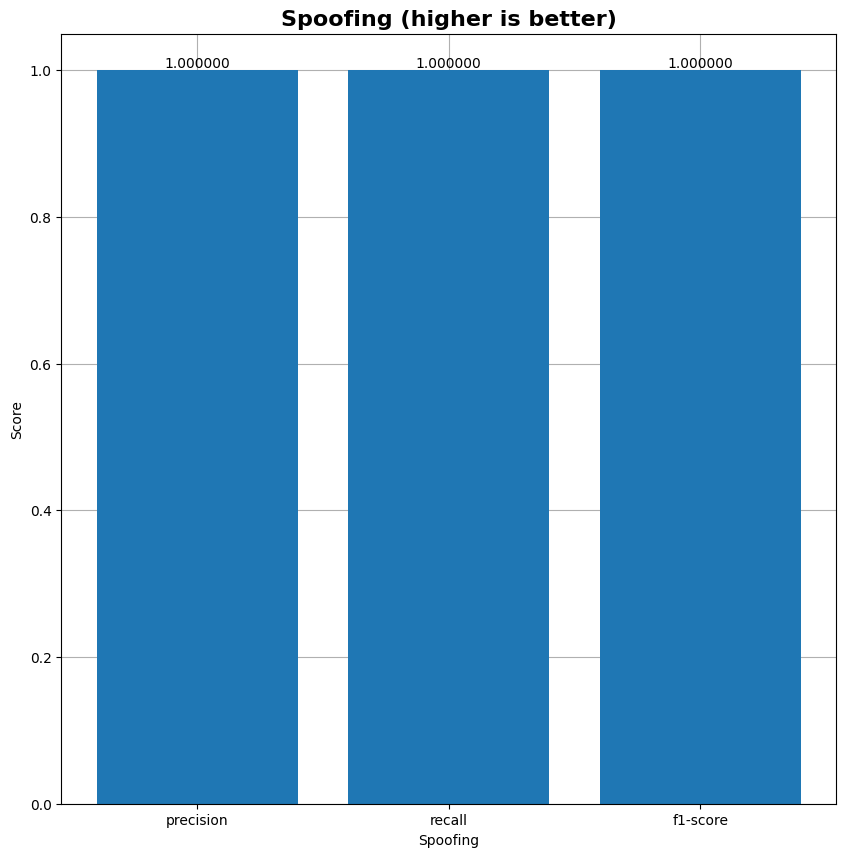

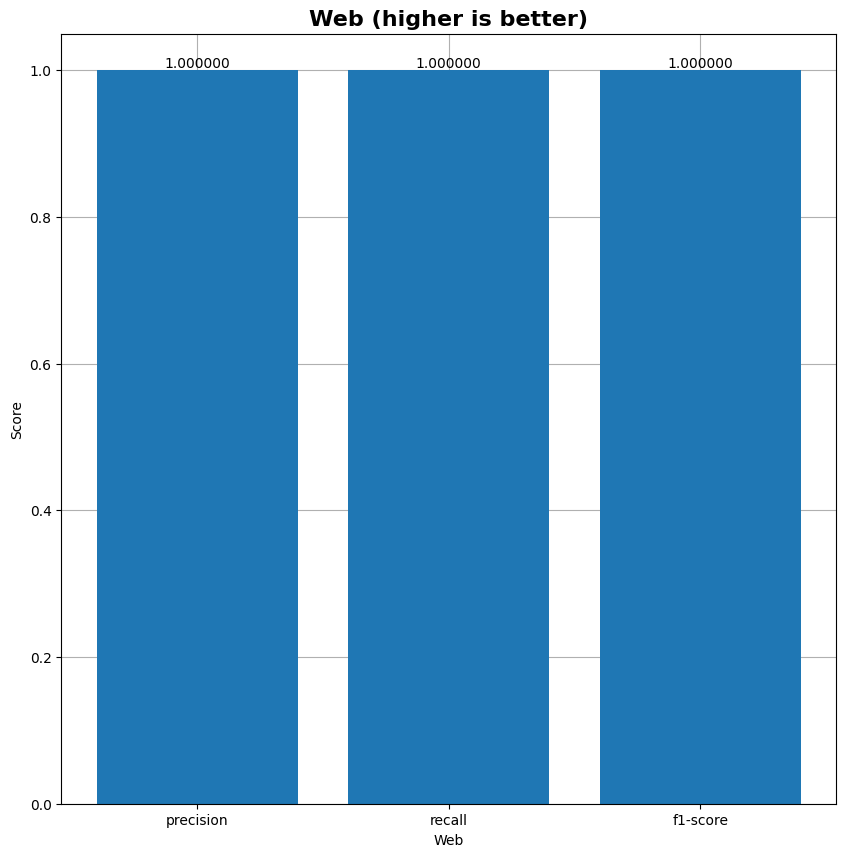

In [94]:
plot_mc(y_pred, y_test, "LSTM")

In [95]:
model_name = "LSTM_5000.sav"
pickle.dump(model, open(model_name, 'wb'))

# Plot data

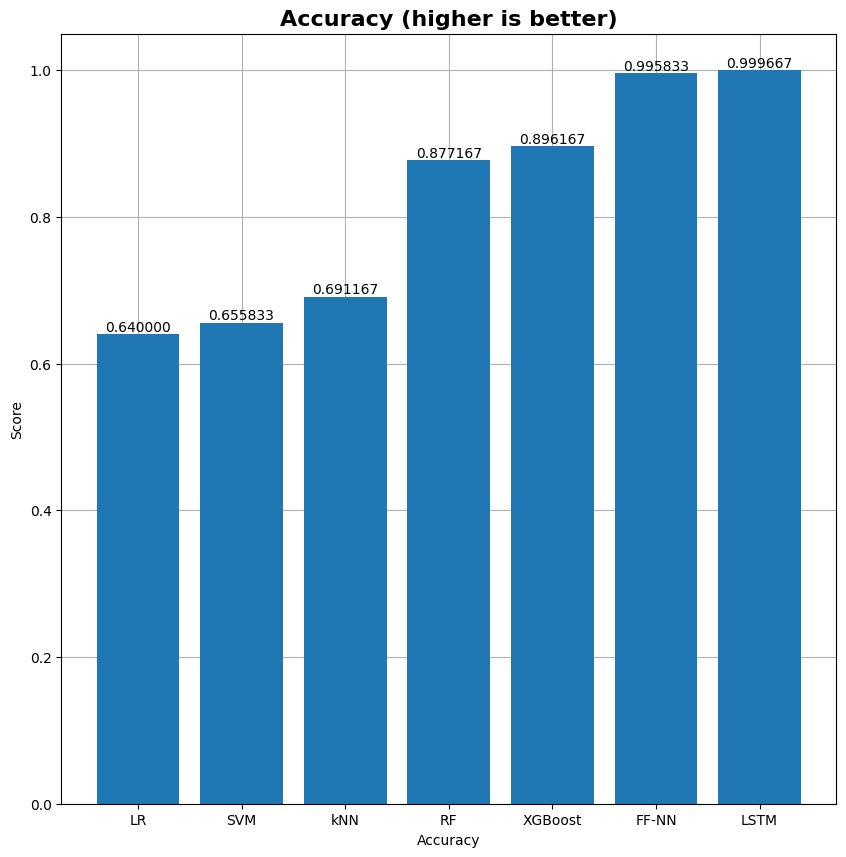

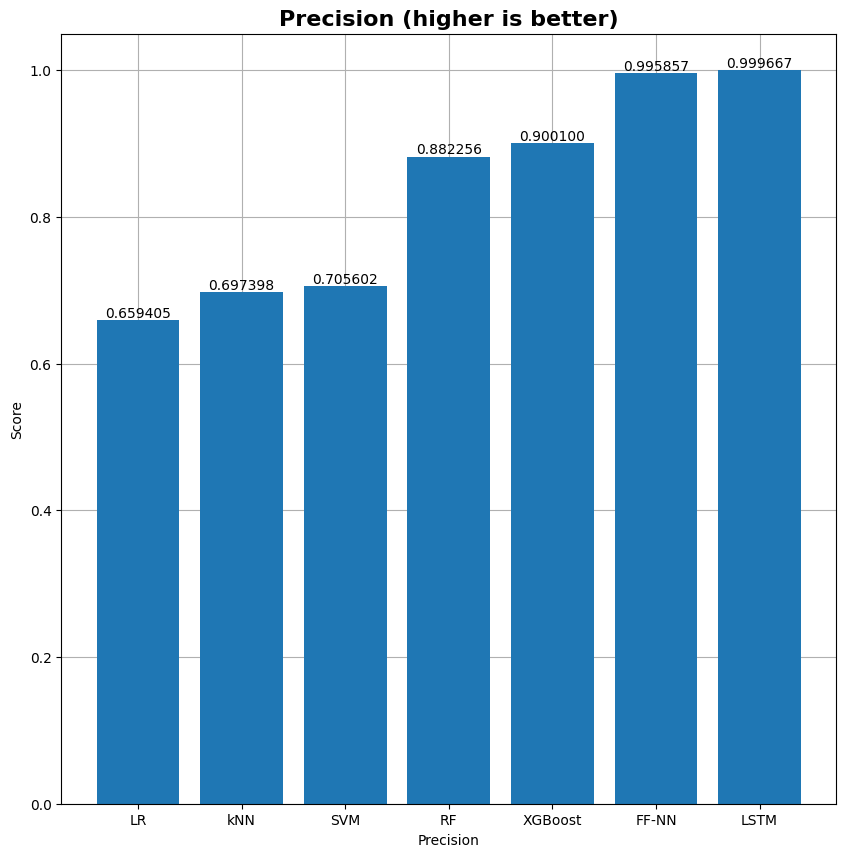

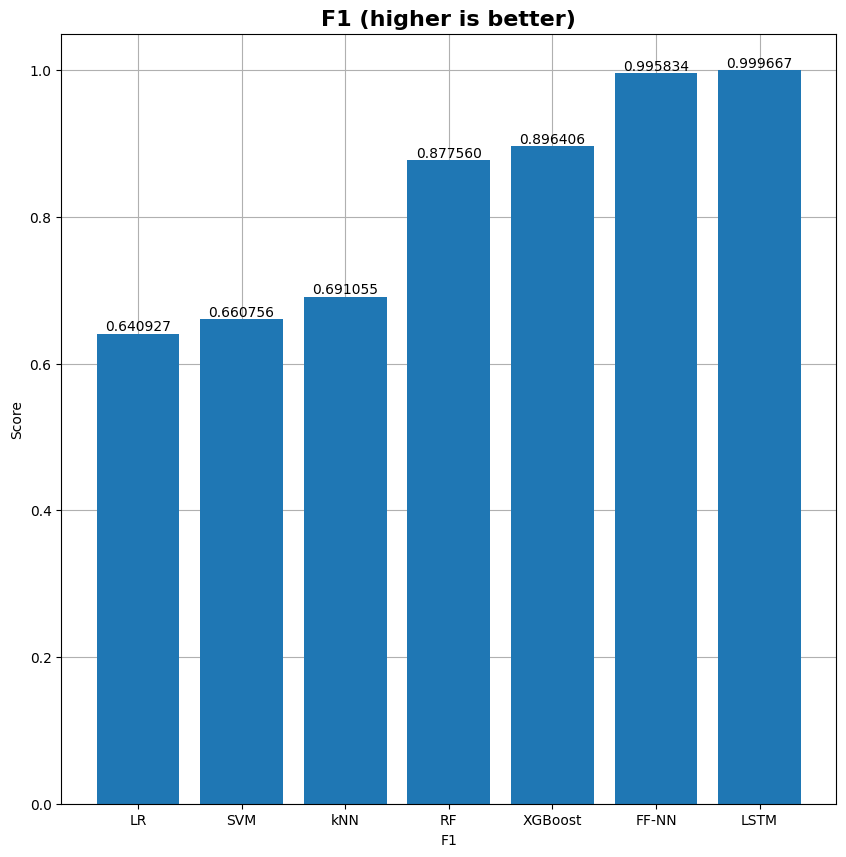

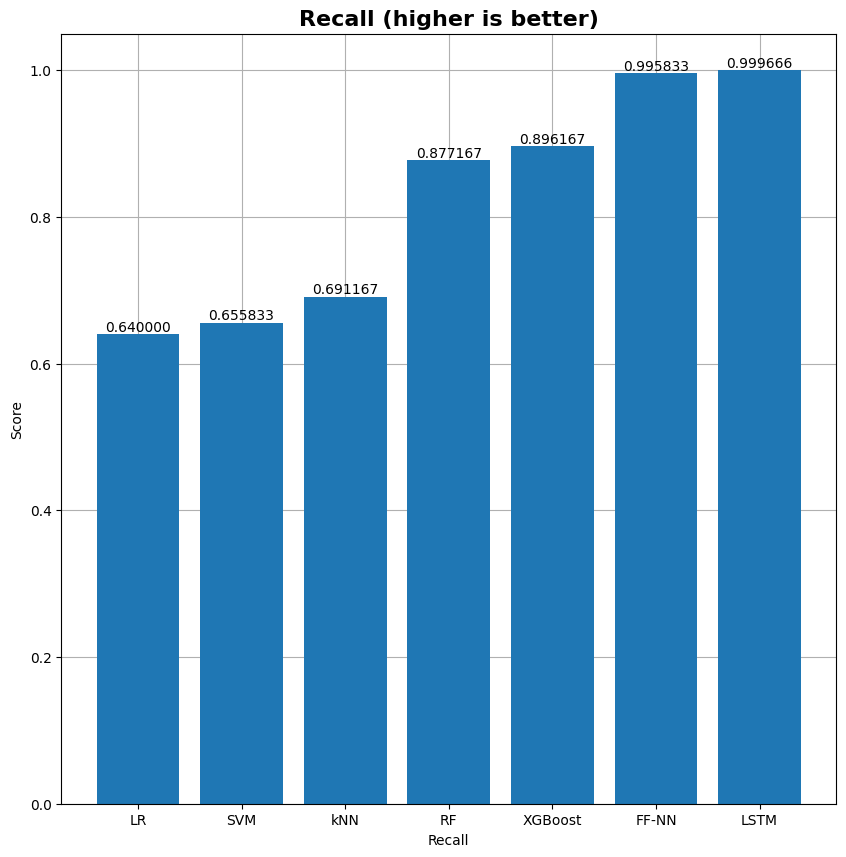

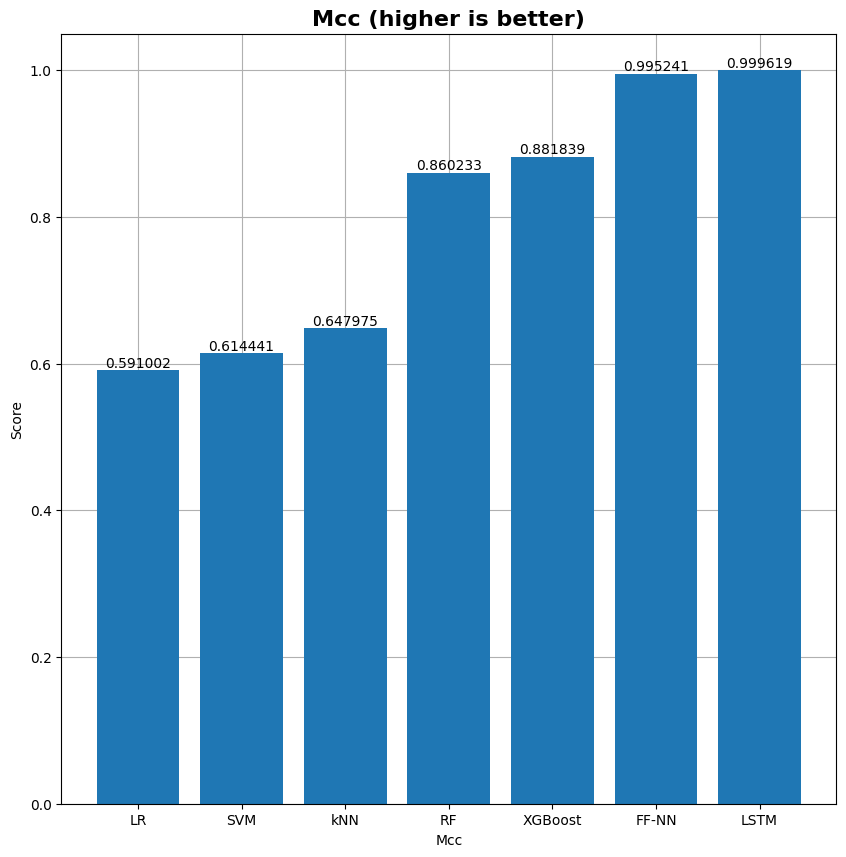

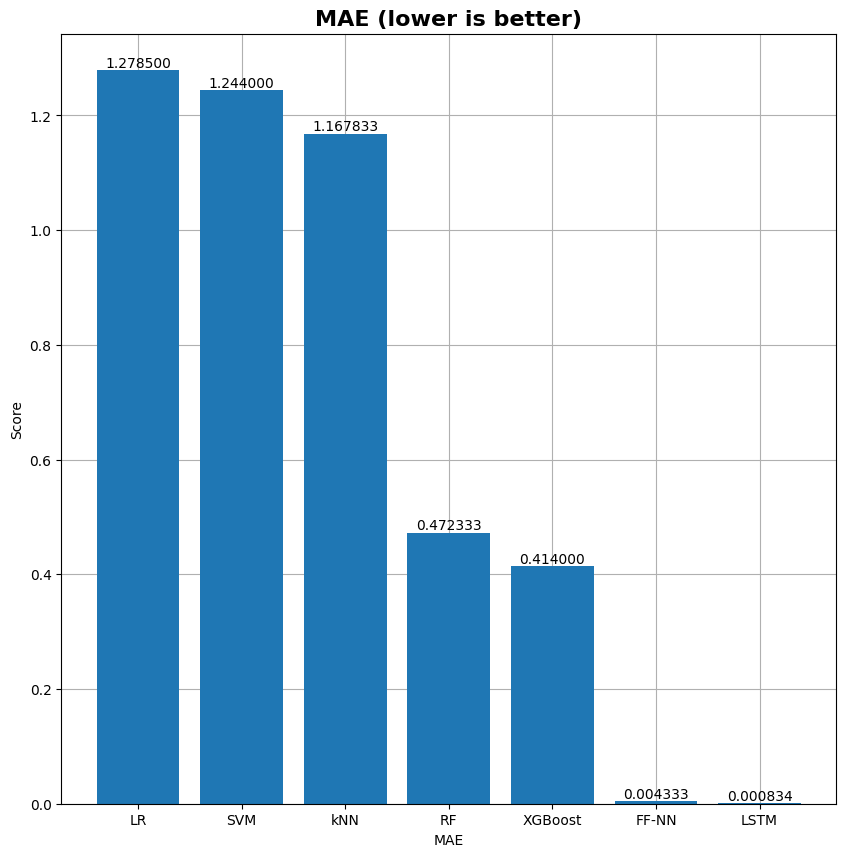

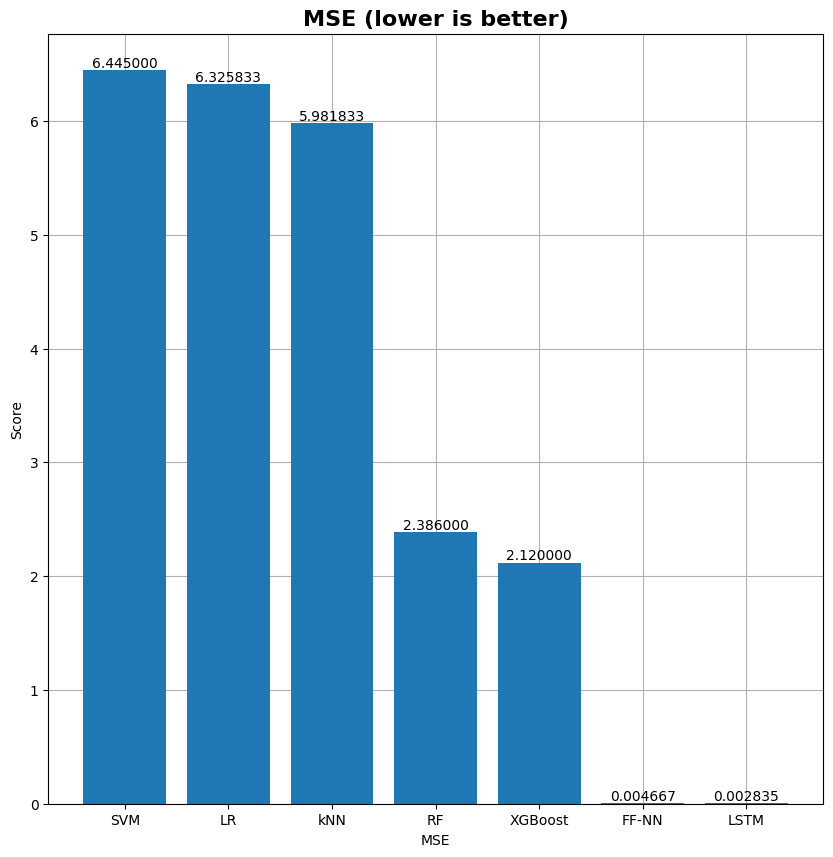

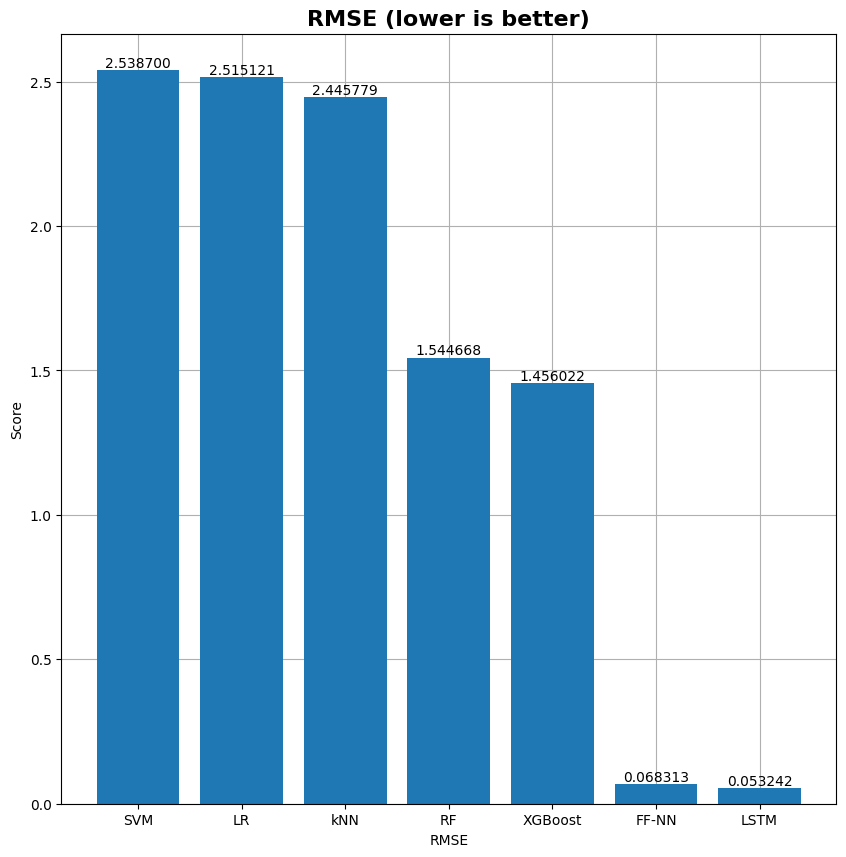

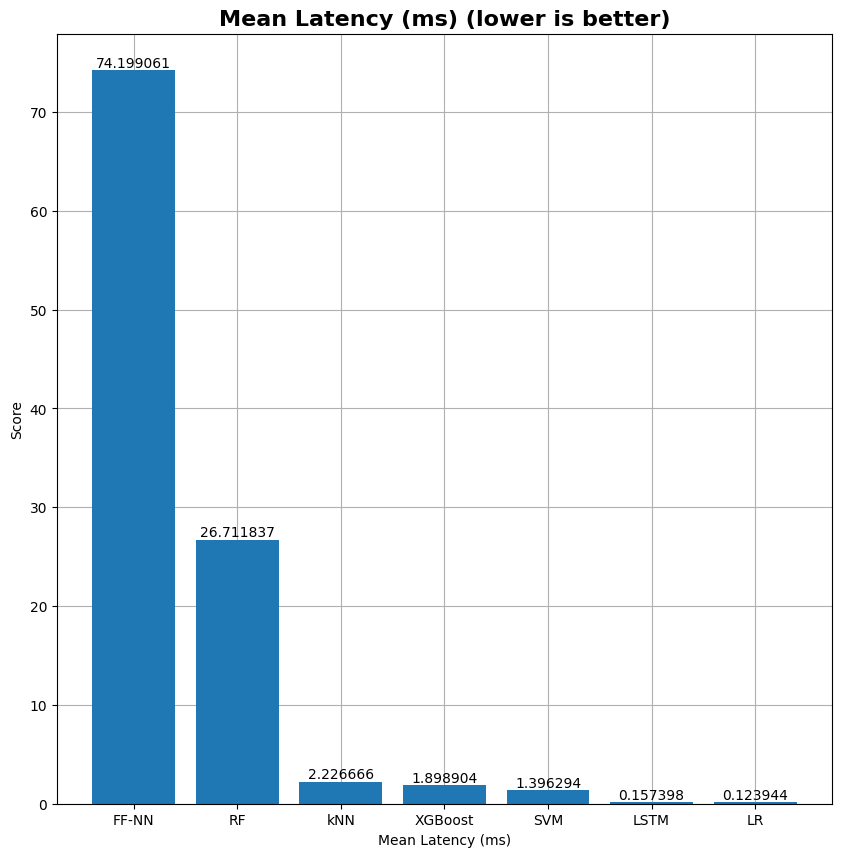

In [ ]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Mean Latency (ms)", "Standard Latency (ms)", "Memory Usage (MB)", "Time"])
for x in results_df:
    _dict = {}
    name = results_df[x].name
    for keys, values in zip(range(len(results_df[x].keys())), results_df[x]):
        _dict[results_df[x].keys()[keys]] = values
    result_plot(_dict, name, "multiclass", "")

# Save results dict

In [ ]:
df_dict = results_df.to_dict()

In [ ]:
values = ['Precision', 'Recall', 'F1']
new_dict = {}
for value in values:
    new_dict[value] = df_dict[value]

In [ ]:
new_dict

In [ ]:
pd.DataFrame(new_dict).transpose()